<a href="https://colab.research.google.com/github/Sonya16-my/test/blob/master/lab_1_linear_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Лабораторная работа "Линейные модели"

Кол-во поинтов за задания:

| № задания  | Кол-во поинтов в классе | Кол-во поинтов дома |
| ------------- | ------------- | ------------- |
| 1 | 2 | 1 |
| 2 | 6 | 4 |
| 3 | 5 | 3 |
| 4 | 1 | 1 |
| 5 | 2 | 1 |
| 6 | 4 | 3 |
| 7 | 5 | 3 |
| 8 | 5 | 3 |
| Всего | 30 | 19 |

Максимум - 30 поинтов

Начнём с загрузки необходимых библиотек и функций.

Параметр `seed` будет использоваться далее для инициализации генератора случайных чисел из библиотеки `numpy`.

In [ ]:
import numpy as np
import pandas as pd
from typing import Optional, List
from sklearn.model_selection import train_test_split

import sklearn.base
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
seed = 24

В этом ноутбуке мы будем практиковаться на датасете ["The Ames Iowa Housing Data"](https://www.openml.org/d/41211). Здесь собраны описания и цены жилья в городе Эймс, штат Айова. Мы будем решать задачу предсказания цены (`Sale_Price`) по всем остальным признакам.

И начнём мы, конечно, с того, что внимательно посмотрим на датасет: какие там есть объекты и какие признаки.

In [ ]:
## Uncomment the line below to download data and install necessary packages

# !pip install numpy pandas sklearn matplotlib
# !curl https://api.openml.org/data/get_csv/20649135/file2ed11cebe25.arff > data.csv

In [ ]:
# Загрузка и первичный осмотр данных

data = pd.read_csv('data.csv')
print("Первые 5 строк данных:")
print(data.head())
print("\nИнформация о данных:")
print(data.info()) # дает информацию о типах данных и пропущенных значениях.
print("\nБазовые статистики:")
print(data.describe()) # выводит базовые статистики (среднее, медиана, мин/макс и т.д.) для числовых столбцов.

Первые 5 строк данных:
                           MS_SubClass                 MS_Zoning  \
0  One_Story_1946_and_Newer_All_Styles   Residential_Low_Density   
1  One_Story_1946_and_Newer_All_Styles  Residential_High_Density   
2  One_Story_1946_and_Newer_All_Styles   Residential_Low_Density   
3  One_Story_1946_and_Newer_All_Styles   Residential_Low_Density   
4             Two_Story_1946_and_Newer   Residential_Low_Density   

   Lot_Frontage  Lot_Area Street            Alley           Lot_Shape  \
0           141     31770   Pave  No_Alley_Access  Slightly_Irregular   
1            80     11622   Pave  No_Alley_Access             Regular   
2            81     14267   Pave  No_Alley_Access  Slightly_Irregular   
3            93     11160   Pave  No_Alley_Access             Regular   
4            74     13830   Pave  No_Alley_Access  Slightly_Irregular   

  Land_Contour Utilities Lot_Config  ...            Fence Misc_Feature  \
0          Lvl    AllPub     Corner  ...         No_Fen

Пропущенные значения по столбцам:
MS_SubClass       0
MS_Zoning         0
Lot_Frontage      0
Lot_Area          0
Street            0
                 ..
Sale_Type         0
Sale_Condition    0
Sale_Price        0
Longitude         0
Latitude          0
Length: 81, dtype: int64


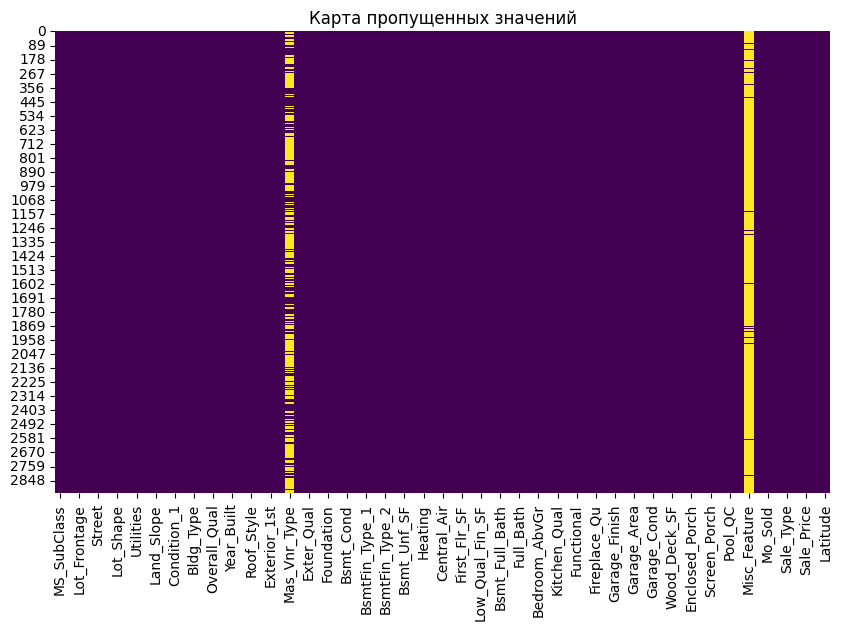


Пропущенные значения после обработки:
MS_SubClass       0
MS_Zoning         0
Lot_Frontage      0
Lot_Area          0
Street            0
                 ..
Sale_Type         0
Sale_Condition    0
Sale_Price        0
Longitude         0
Latitude          0
Length: 81, dtype: int64


In [ ]:
# Проверка пропущенных значений и их обработка

# Проверяем пропущенные значения
print("Пропущенные значения по столбцам:")
print(data.isnull().sum()) # подсчитывает пропуски по столбцам.

# Визуализация пропущенных значений
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis') # тепловая карта, визуально показывает, где сосредоточены пропуски
plt.title("Карта пропущенных значений")
plt.show()

# Пример обработки пропусков
# Числовые столбцы заполняем медианой, категориальные — модой
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = data.select_dtypes(include=['object']).columns

imputer_num = SimpleImputer(strategy='median')
imputer_cat = SimpleImputer(strategy='most_frequent')

data[numeric_cols] = imputer_num.fit_transform(data[numeric_cols])
data[categorical_cols] = imputer_cat.fit_transform(data[categorical_cols])

print("\nПропущенные значения после обработки:")
print(data.isnull().sum())


Уникальные значения в MS_SubClass:
MS_SubClass
One_Story_1946_and_Newer_All_Styles          1079
Two_Story_1946_and_Newer                      575
One_and_Half_Story_Finished_All_Ages          287
One_Story_PUD_1946_and_Newer                  192
One_Story_1945_and_Older                      139
Two_Story_PUD_1946_and_Newer                  129
Two_Story_1945_and_Older                      128
Split_or_Multilevel                           118
Duplex_All_Styles_and_Ages                    109
Two_Family_conversion_All_Styles_and_Ages      61
Split_Foyer                                    48
Two_and_Half_Story_All_Ages                    23
One_and_Half_Story_Unfinished_All_Ages         18
PUD_Multilevel_Split_Level_Foyer               17
One_Story_with_Finished_Attic_All_Ages          6
One_and_Half_Story_PUD_All_Ages                 1
Name: count, dtype: int64


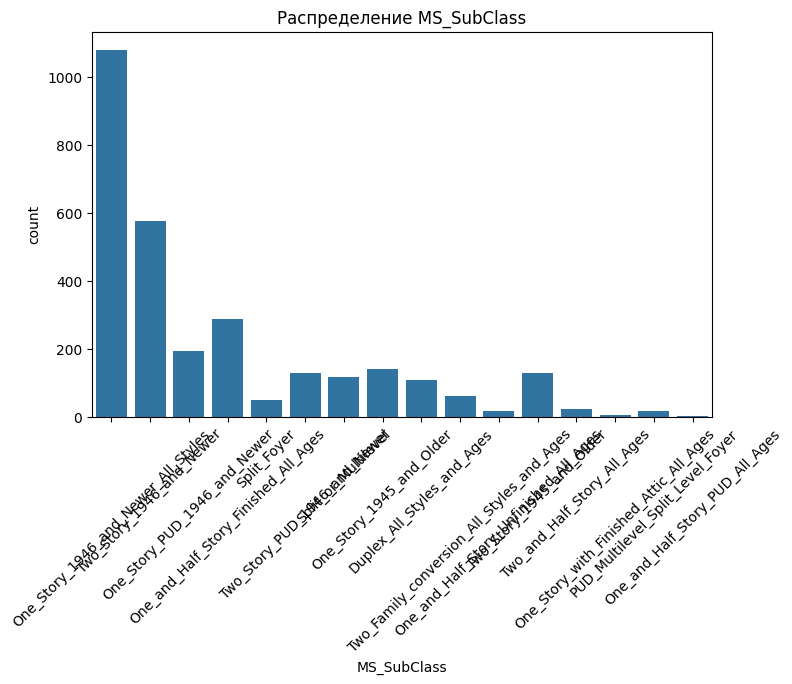


Уникальные значения в MS_Zoning:
MS_Zoning
Residential_Low_Density         2273
Residential_Medium_Density       462
Floating_Village_Residential     139
Residential_High_Density          27
C_all                             25
I_all                              2
A_agr                              2
Name: count, dtype: int64


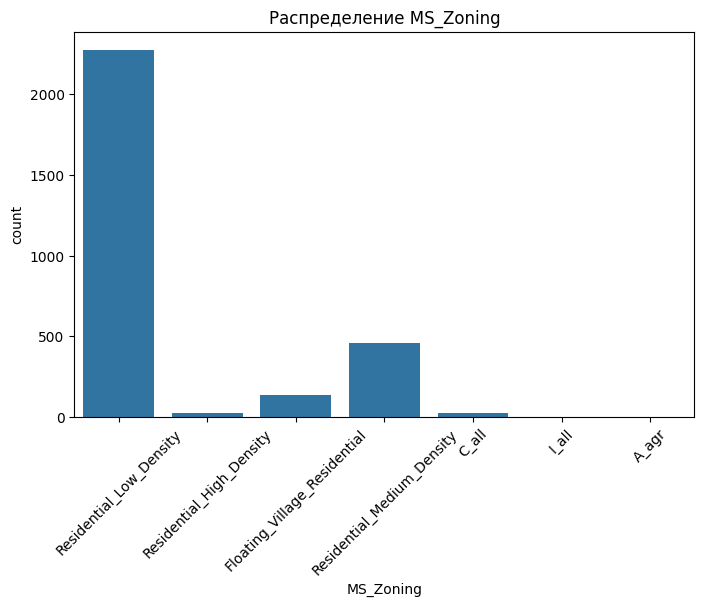


Уникальные значения в Street:
Street
Pave    2918
Grvl      12
Name: count, dtype: int64


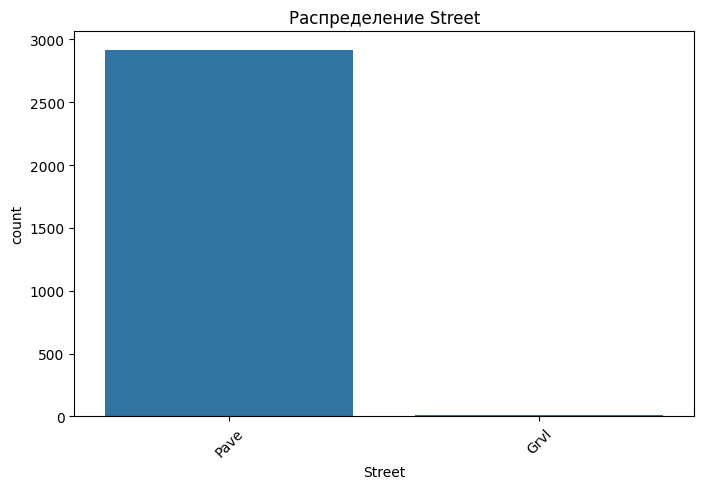


Уникальные значения в Alley:
Alley
No_Alley_Access    2732
Gravel              120
Paved                78
Name: count, dtype: int64


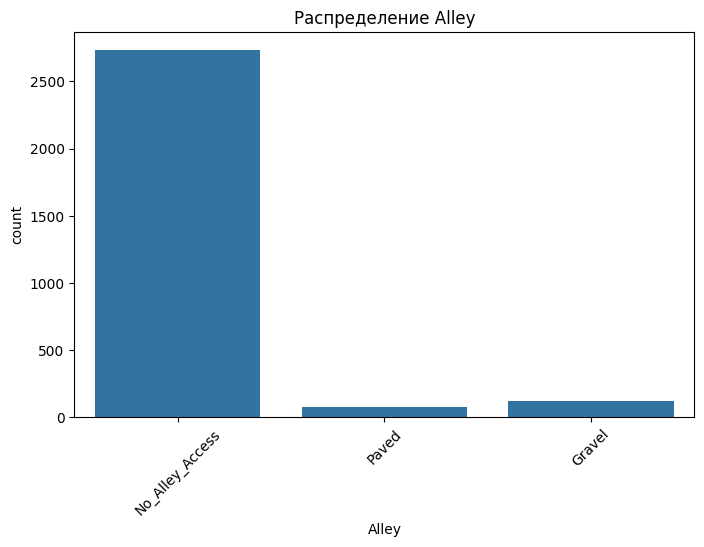


Уникальные значения в Lot_Shape:
Lot_Shape
Regular                 1859
Slightly_Irregular       979
Moderately_Irregular      76
Irregular                 16
Name: count, dtype: int64


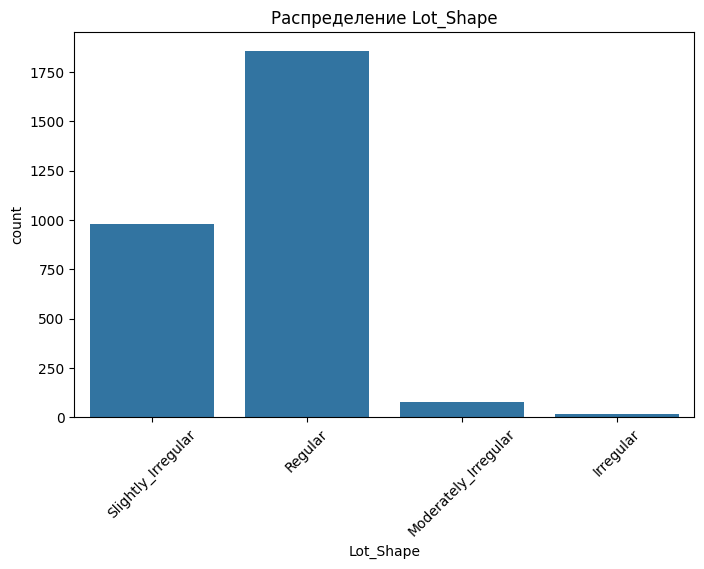


Уникальные значения в Land_Contour:
Land_Contour
Lvl    2633
HLS     120
Bnk     117
Low      60
Name: count, dtype: int64


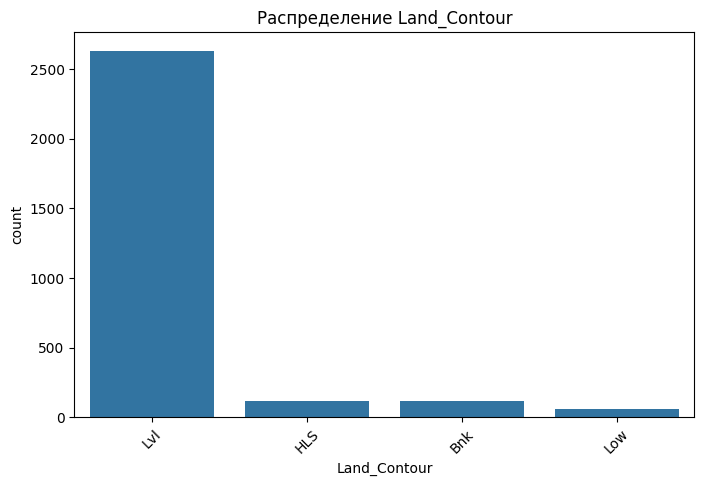


Уникальные значения в Utilities:
Utilities
AllPub    2927
NoSewr       2
NoSeWa       1
Name: count, dtype: int64


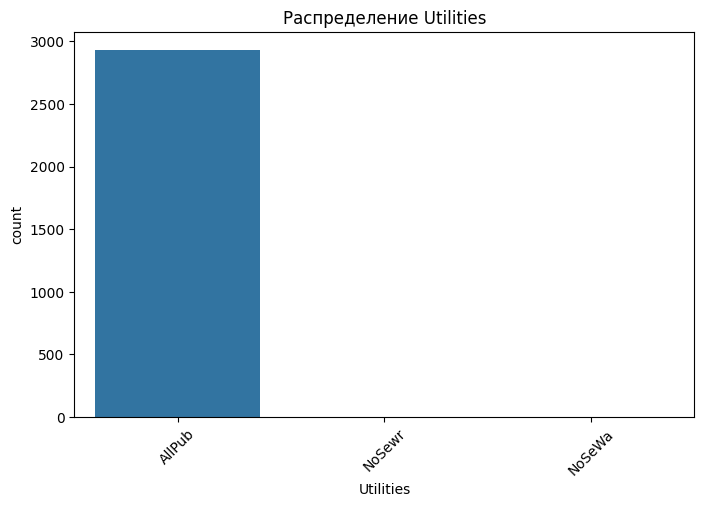


Уникальные значения в Lot_Config:
Lot_Config
Inside     2140
Corner      511
CulDSac     180
FR2          85
FR3          14
Name: count, dtype: int64


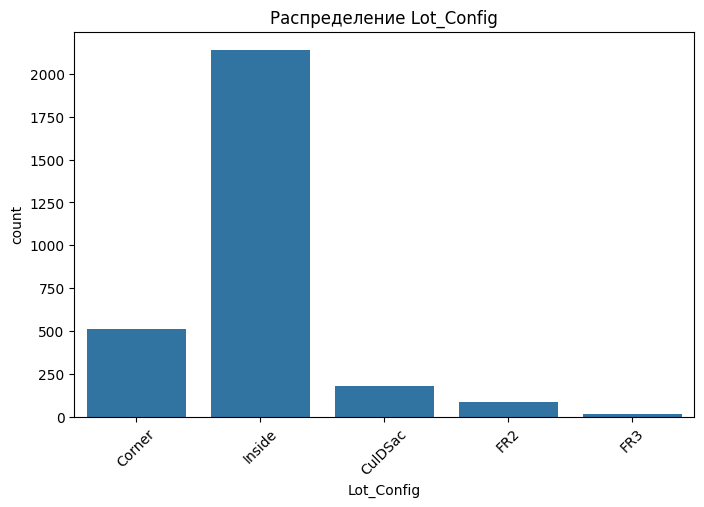


Уникальные значения в Land_Slope:
Land_Slope
Gtl    2789
Mod     125
Sev      16
Name: count, dtype: int64


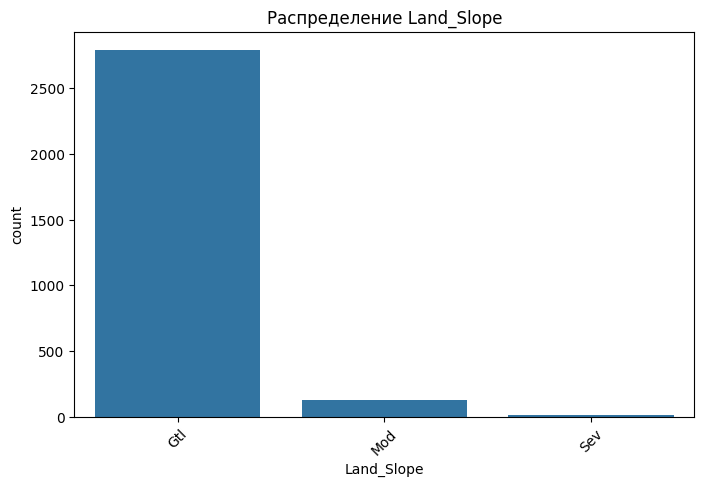


Уникальные значения в Neighborhood:
Neighborhood
North_Ames                                 443
College_Creek                              267
Old_Town                                   239
Edwards                                    194
Somerset                                   182
Northridge_Heights                         166
Gilbert                                    165
Sawyer                                     151
Northwest_Ames                             131
Sawyer_West                                125
Mitchell                                   114
Brookside                                  108
Crawford                                   103
Iowa_DOT_and_Rail_Road                      93
Timberland                                  72
Northridge                                  71
Stone_Brook                                 51
South_and_West_of_Iowa_State_University     48
Clear_Creek                                 44
Meadow_Village                              37
Briardale 

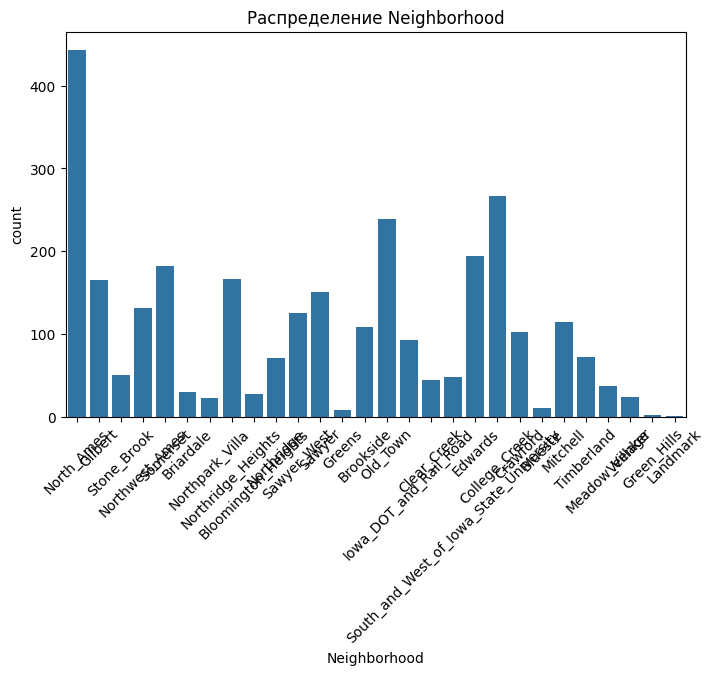


Уникальные значения в Condition_1:
Condition_1
Norm      2522
Feedr      164
Artery      92
RRAn        50
PosN        39
RRAe        28
PosA        20
RRNn         9
RRNe         6
Name: count, dtype: int64


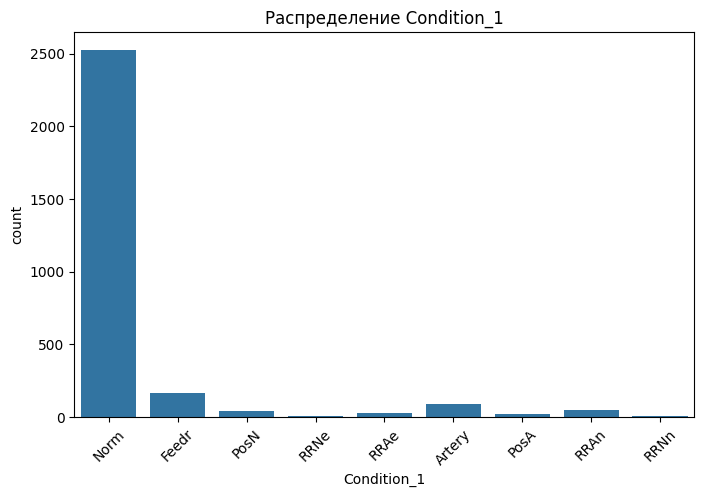


Уникальные значения в Condition_2:
Condition_2
Norm      2900
Feedr       13
Artery       5
PosA         4
PosN         4
RRNn         2
RRAe         1
RRAn         1
Name: count, dtype: int64


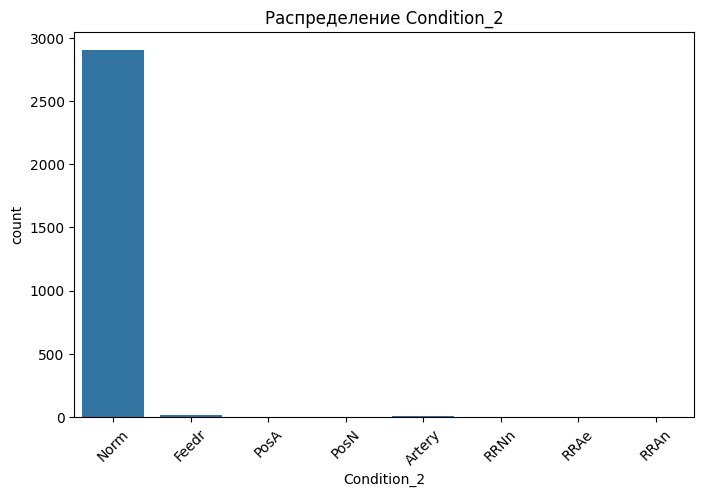


Уникальные значения в Bldg_Type:
Bldg_Type
OneFam      2425
TwnhsE       233
Duplex       109
Twnhs        101
TwoFmCon      62
Name: count, dtype: int64


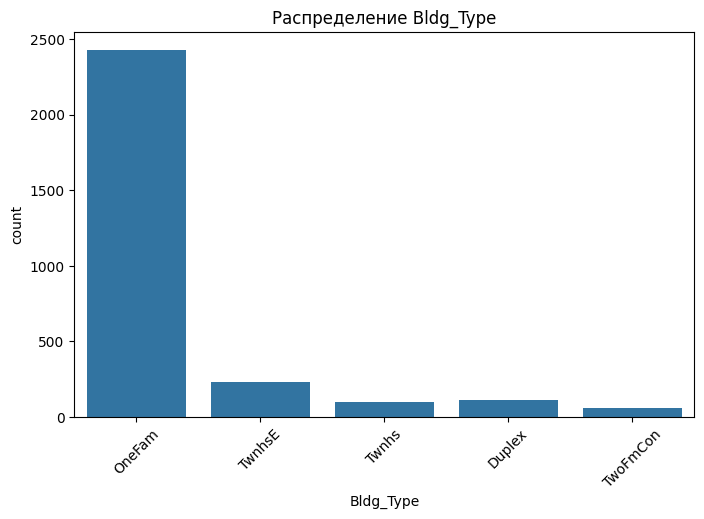


Уникальные значения в House_Style:
House_Style
One_Story           1481
Two_Story            873
One_and_Half_Fin     314
SLvl                 128
SFoyer                83
Two_and_Half_Unf      24
One_and_Half_Unf      19
Two_and_Half_Fin       8
Name: count, dtype: int64


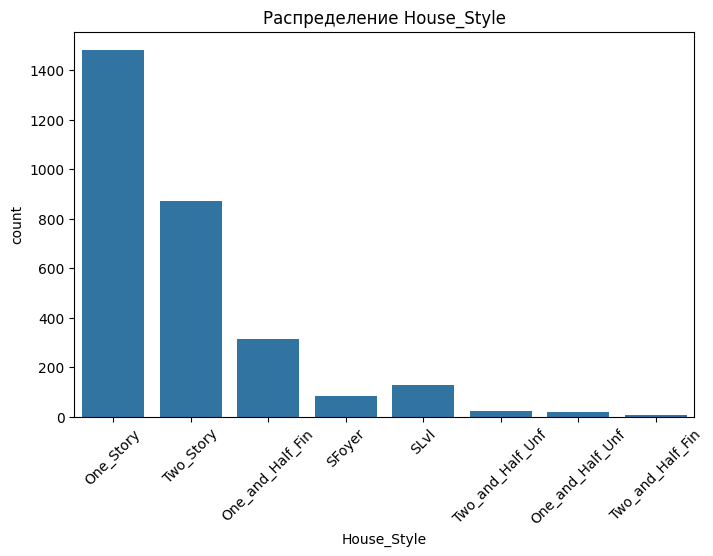


Уникальные значения в Overall_Qual:
Overall_Qual
Average           825
Above_Average     732
Good              602
Very_Good         350
Below_Average     226
Excellent         107
Fair               40
Very_Excellent     31
Poor               13
Very_Poor           4
Name: count, dtype: int64


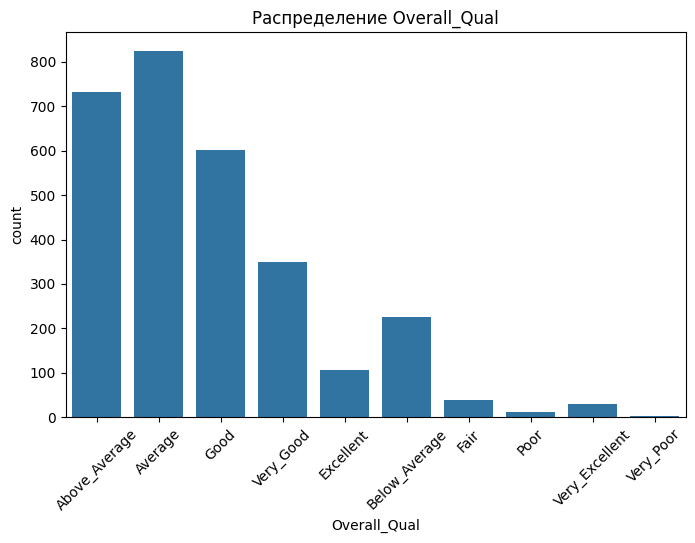


Уникальные значения в Overall_Cond:
Overall_Cond
Average          1654
Above_Average     533
Good              390
Very_Good         144
Below_Average     101
Fair               50
Excellent          41
Poor               10
Very_Poor           7
Name: count, dtype: int64


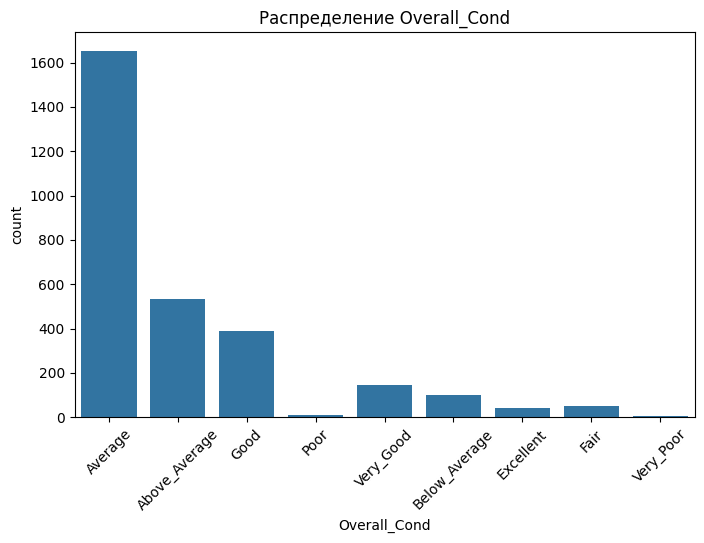


Уникальные значения в Roof_Style:
Roof_Style
Gable      2321
Hip         551
Gambrel      22
Flat         20
Mansard      11
Shed          5
Name: count, dtype: int64


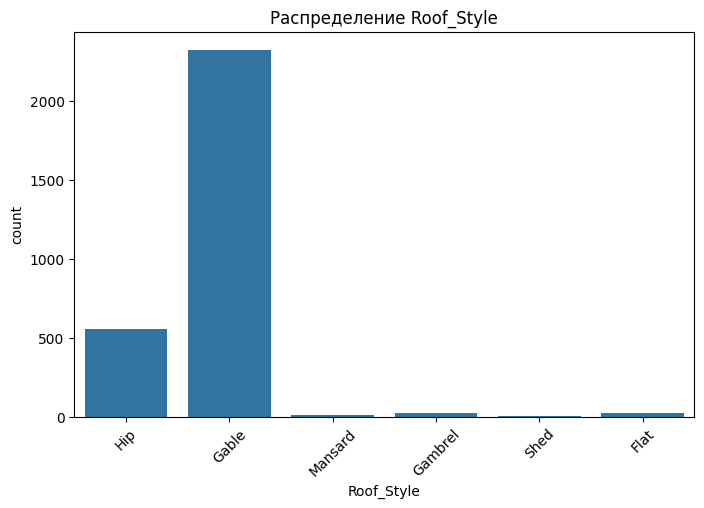


Уникальные значения в Roof_Matl:
Roof_Matl
CompShg    2887
Tar&Grv      23
WdShake       9
WdShngl       7
Membran       1
ClyTile       1
Roll          1
Metal         1
Name: count, dtype: int64


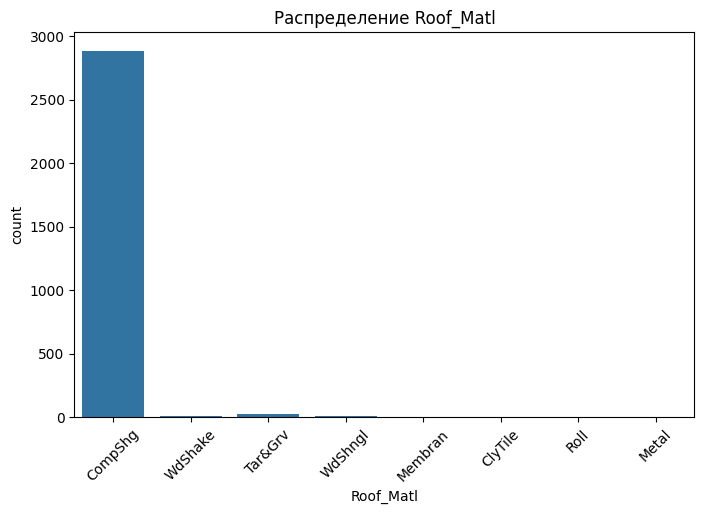


Уникальные значения в Exterior_1st:
Exterior_1st
VinylSd    1026
MetalSd     450
HdBoard     442
Wd Sdng     420
Plywood     221
CemntBd     126
BrkFace      88
WdShing      56
AsbShng      44
Stucco       43
BrkComm       6
AsphShn       2
CBlock        2
Stone         2
PreCast       1
ImStucc       1
Name: count, dtype: int64


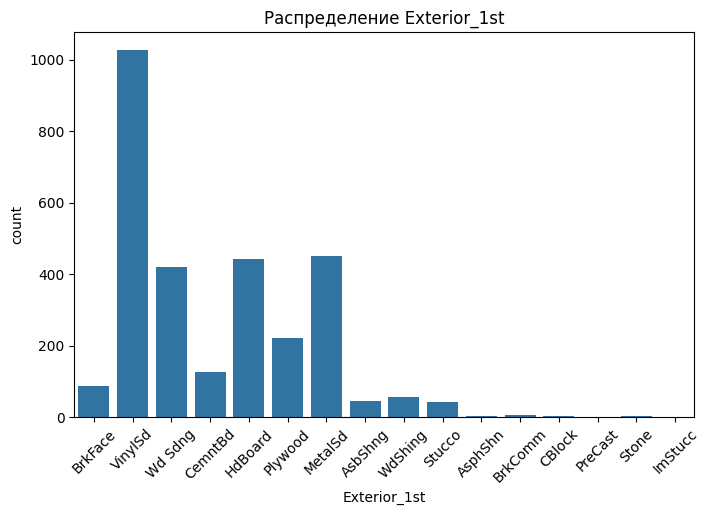


Уникальные значения в Exterior_2nd:
Exterior_2nd
VinylSd    1015
MetalSd     447
HdBoard     406
Wd Sdng     397
Plywood     274
CmentBd     126
Wd Shng      81
BrkFace      47
Stucco       47
AsbShng      38
Brk Cmn      22
ImStucc      15
Stone         6
AsphShn       4
CBlock        3
PreCast       1
Other         1
Name: count, dtype: int64


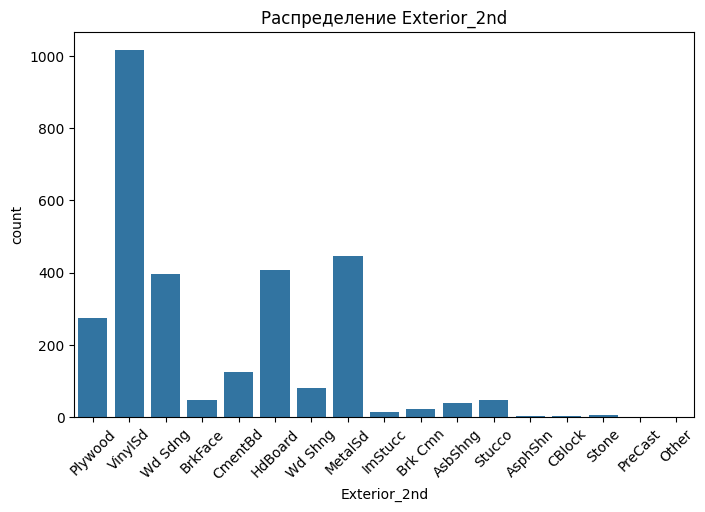


Уникальные значения в Mas_Vnr_Type:
Mas_Vnr_Type
BrkFace    2655
Stone       249
BrkCmn       25
CBlock        1
Name: count, dtype: int64


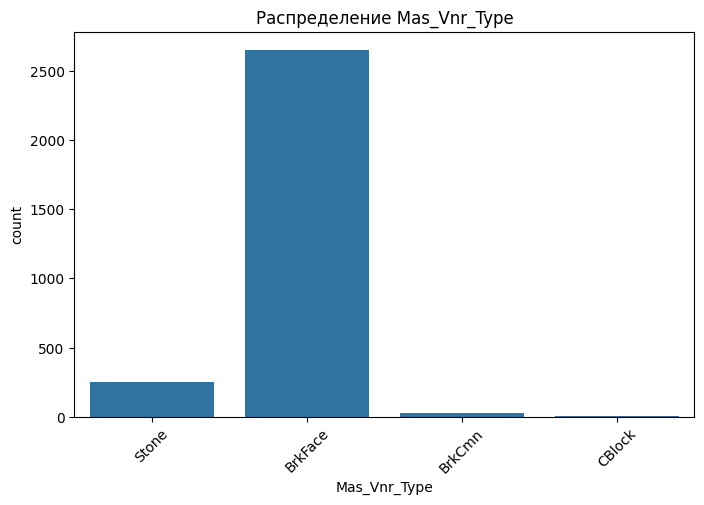


Уникальные значения в Exter_Qual:
Exter_Qual
Typical      1799
Good          989
Excellent     107
Fair           35
Name: count, dtype: int64


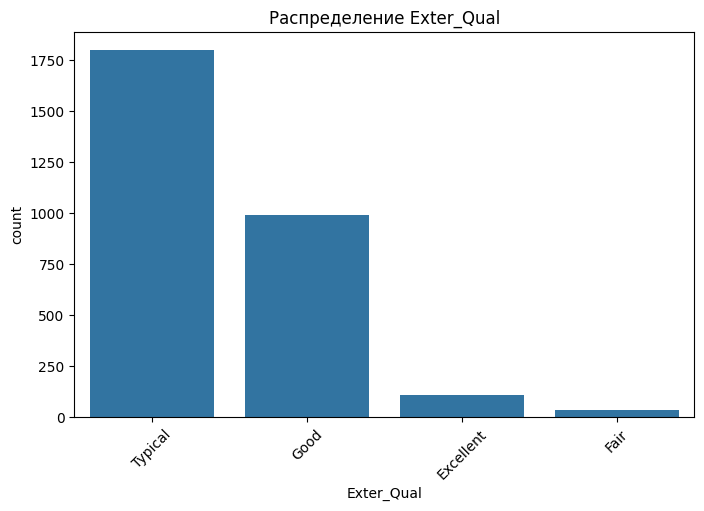


Уникальные значения в Exter_Cond:
Exter_Cond
Typical      2549
Good          299
Fair           67
Excellent      12
Poor            3
Name: count, dtype: int64


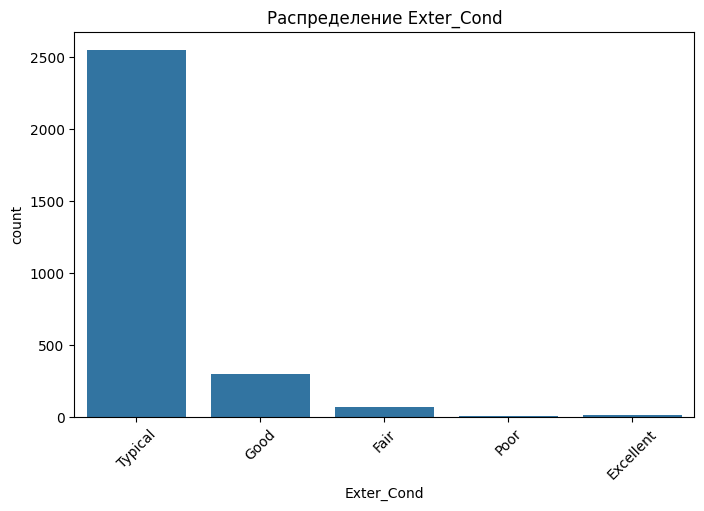


Уникальные значения в Foundation:
Foundation
PConc     1310
CBlock    1244
BrkTil     311
Slab        49
Stone       11
Wood         5
Name: count, dtype: int64


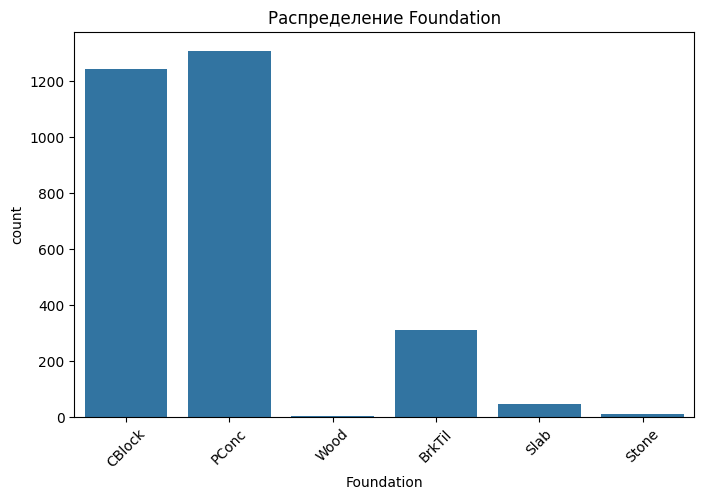


Уникальные значения в Bsmt_Qual:
Bsmt_Qual
Typical        1283
Good           1219
Excellent       258
Fair             88
No_Basement      80
Poor              2
Name: count, dtype: int64


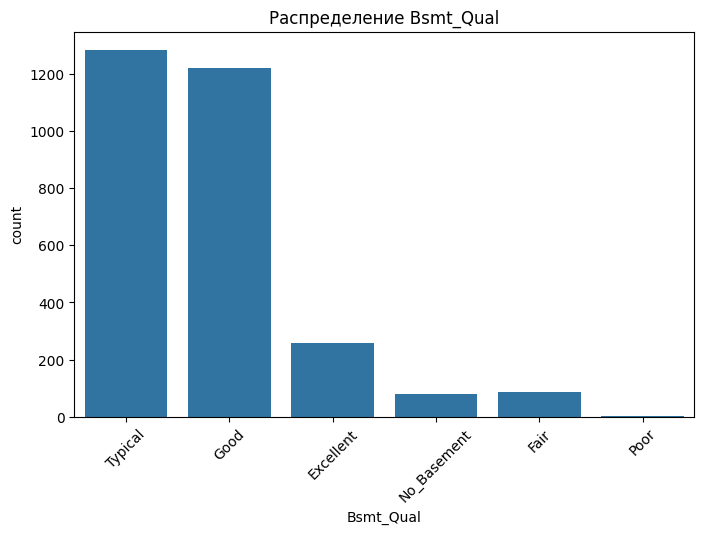


Уникальные значения в Bsmt_Cond:
Bsmt_Cond
Typical        2616
Good            122
Fair            104
No_Basement      80
Poor              5
Excellent         3
Name: count, dtype: int64


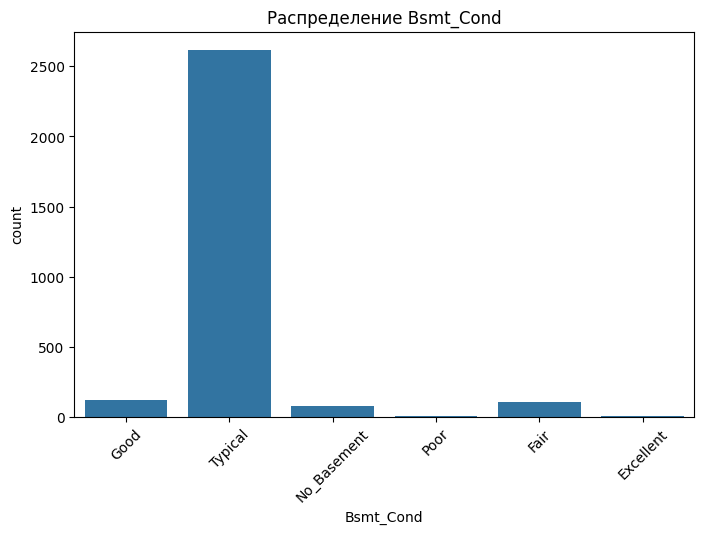


Уникальные значения в Bsmt_Exposure:
Bsmt_Exposure
No             1906
Av              418
Gd              284
Mn              239
No_Basement      83
Name: count, dtype: int64


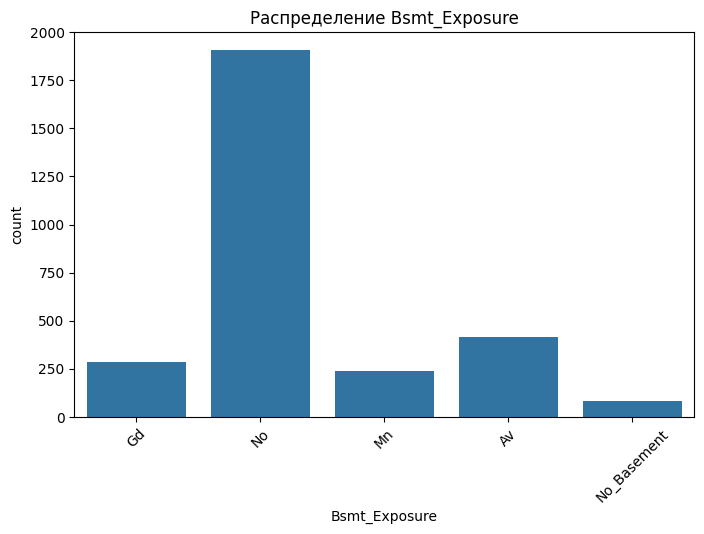


Уникальные значения в BsmtFin_Type_1:
BsmtFin_Type_1
GLQ            859
Unf            851
ALQ            429
Rec            288
BLQ            269
LwQ            154
No_Basement     80
Name: count, dtype: int64


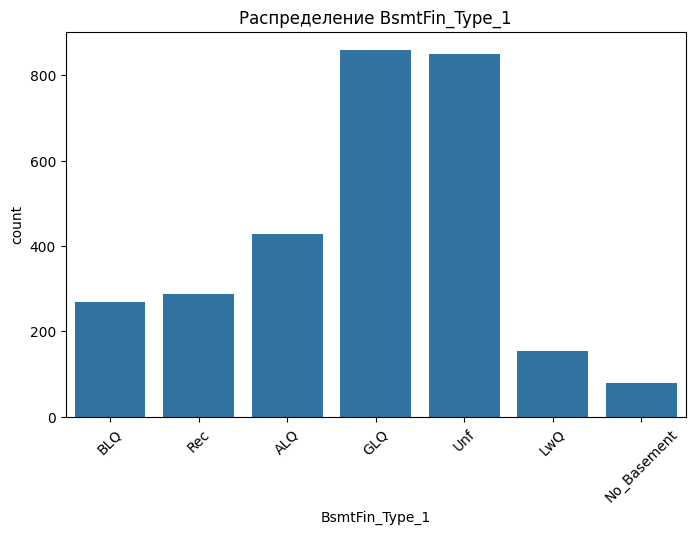


Уникальные значения в BsmtFin_Type_2:
BsmtFin_Type_2
Unf            2499
Rec             106
LwQ              89
No_Basement      81
BLQ              68
ALQ              53
GLQ              34
Name: count, dtype: int64


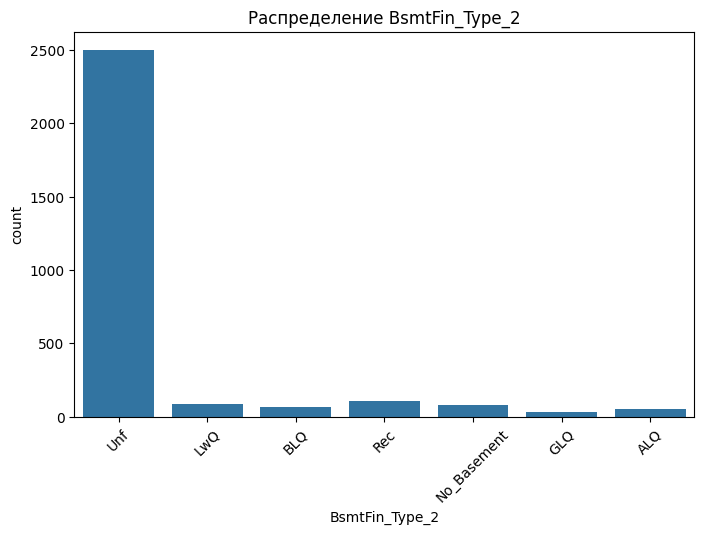


Уникальные значения в Heating:
Heating
GasA     2885
GasW       27
Grav        9
Wall        6
OthW        2
Floor       1
Name: count, dtype: int64


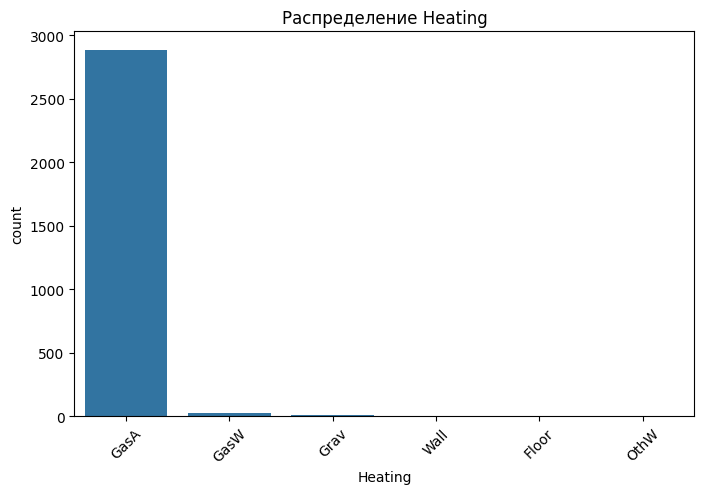


Уникальные значения в Heating_QC:
Heating_QC
Excellent    1495
Typical       864
Good          476
Fair           92
Poor            3
Name: count, dtype: int64


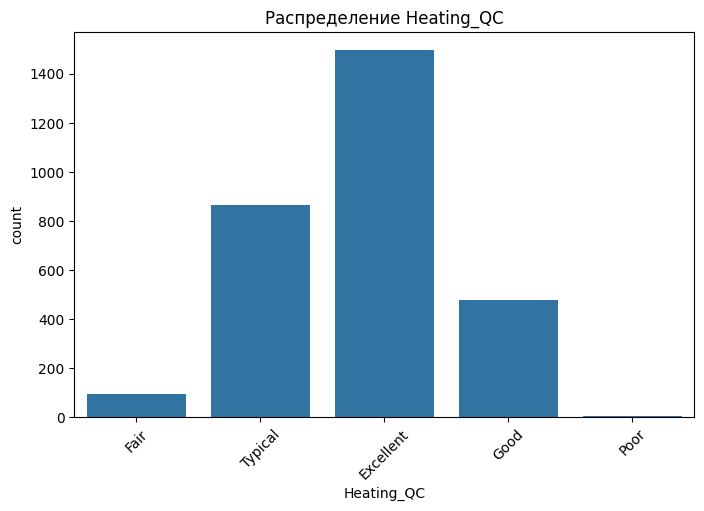


Уникальные значения в Central_Air:
Central_Air
Y    2734
N     196
Name: count, dtype: int64


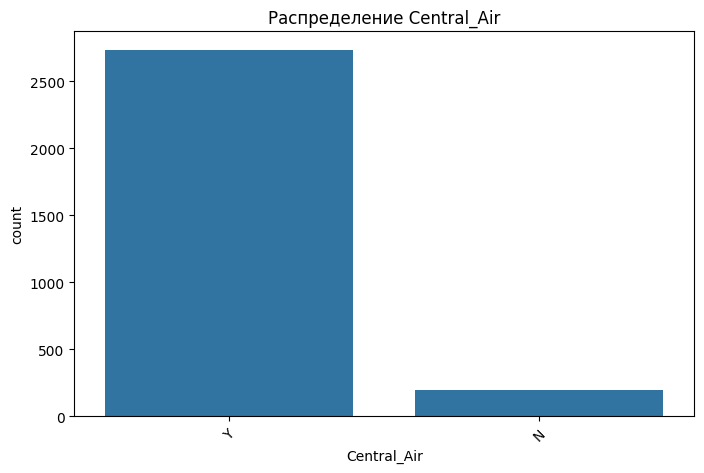


Уникальные значения в Electrical:
Electrical
SBrkr      2682
FuseA       188
FuseF        50
FuseP         8
Unknown       1
Mix           1
Name: count, dtype: int64


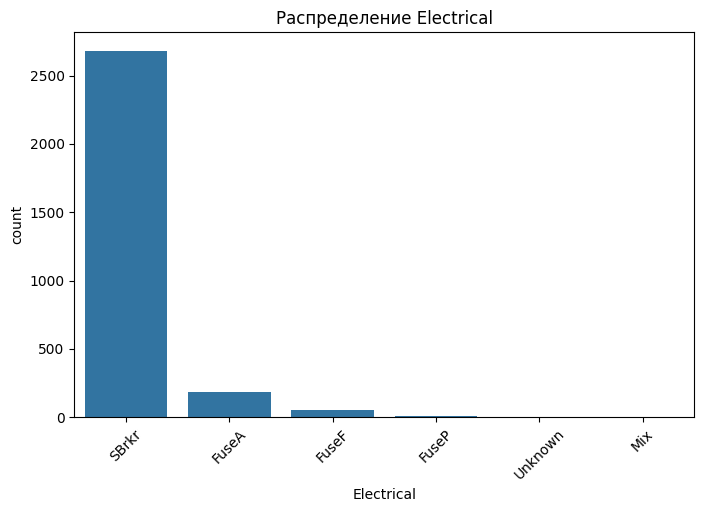


Уникальные значения в Kitchen_Qual:
Kitchen_Qual
Typical      1494
Good         1160
Excellent     205
Fair           70
Poor            1
Name: count, dtype: int64


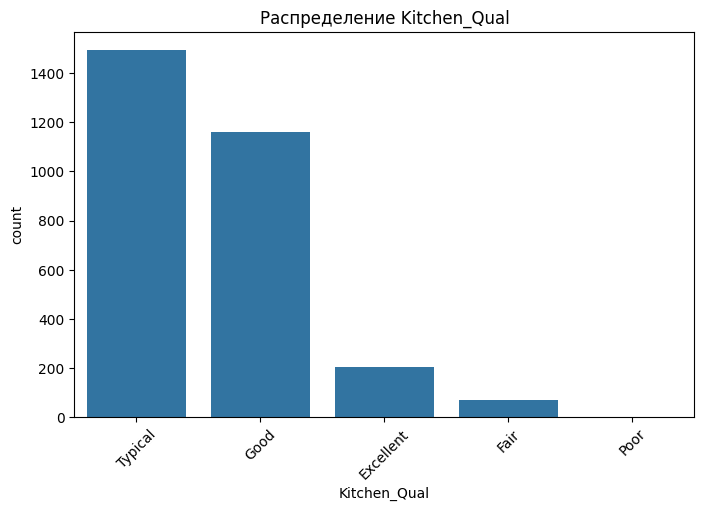


Уникальные значения в Functional:
Functional
Typ     2728
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Sal        2
Name: count, dtype: int64


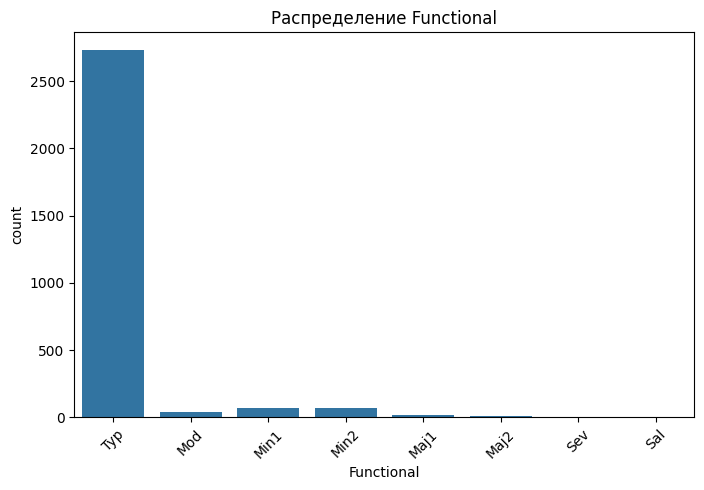


Уникальные значения в Fireplace_Qu:
Fireplace_Qu
No_Fireplace    1422
Good             744
Typical          600
Fair              75
Poor              46
Excellent         43
Name: count, dtype: int64


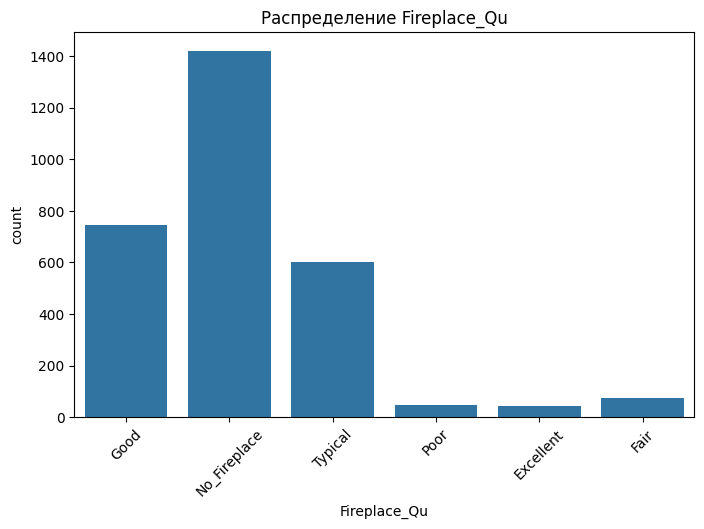


Уникальные значения в Garage_Type:
Garage_Type
Attchd                 1731
Detchd                  782
BuiltIn                 186
No_Garage               157
Basment                  36
More_Than_Two_Types      23
CarPort                  15
Name: count, dtype: int64


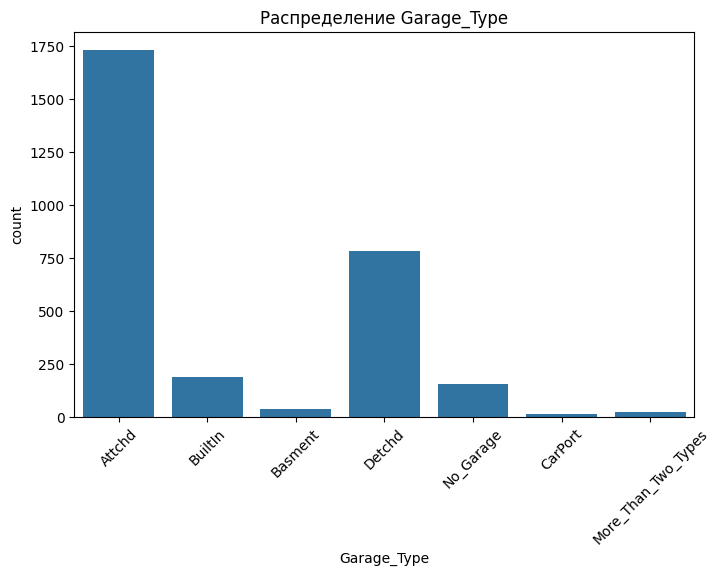


Уникальные значения в Garage_Finish:
Garage_Finish
Unf          1231
RFn           812
Fin           728
No_Garage     159
Name: count, dtype: int64


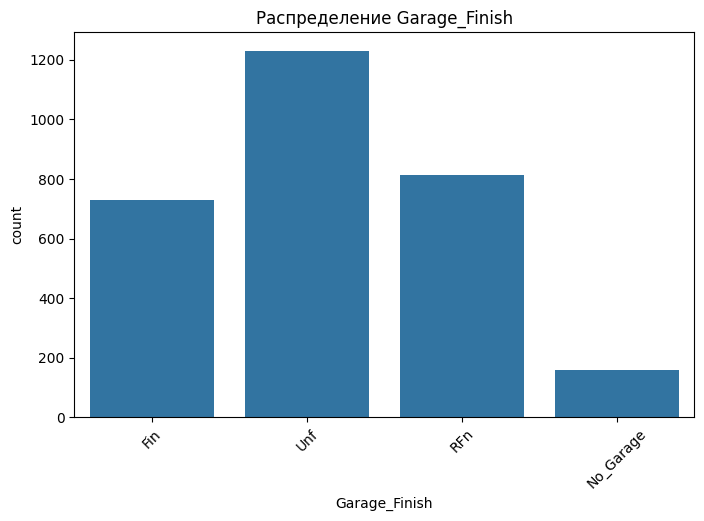


Уникальные значения в Garage_Qual:
Garage_Qual
Typical      2615
No_Garage     159
Fair          124
Good           24
Poor            5
Excellent       3
Name: count, dtype: int64


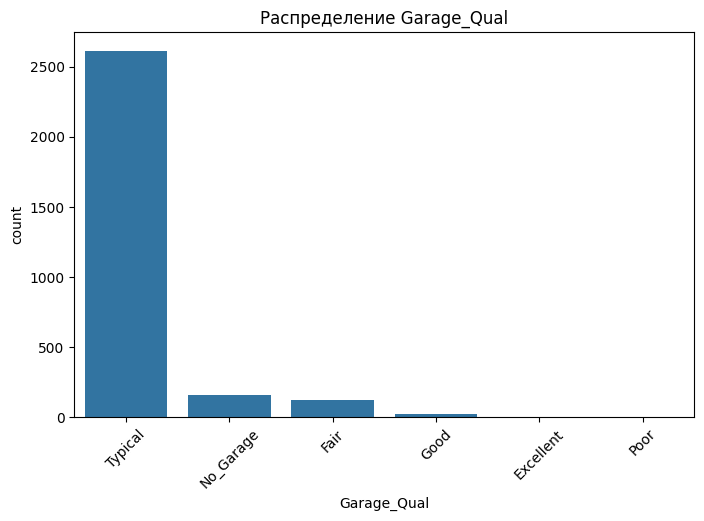


Уникальные значения в Garage_Cond:
Garage_Cond
Typical      2665
No_Garage     159
Fair           74
Good           15
Poor           14
Excellent       3
Name: count, dtype: int64


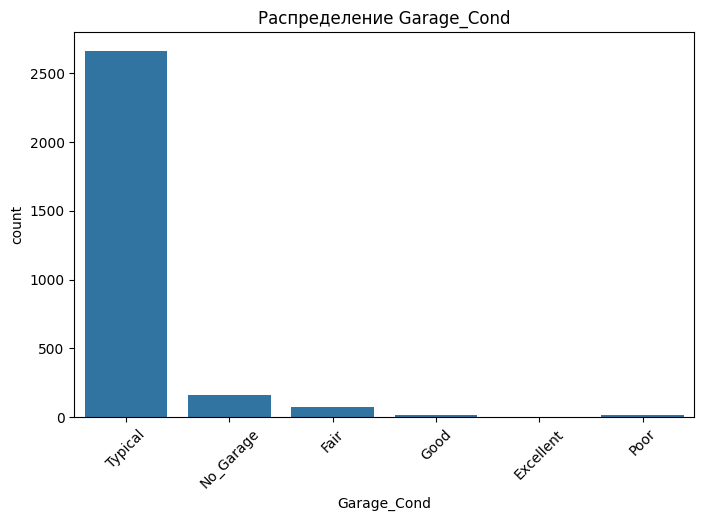


Уникальные значения в Paved_Drive:
Paved_Drive
Paved               2652
Dirt_Gravel          216
Partial_Pavement      62
Name: count, dtype: int64


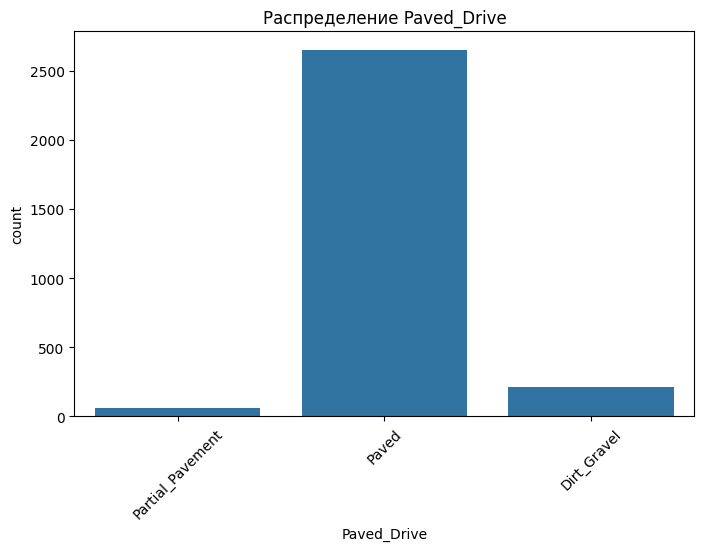


Уникальные значения в Pool_QC:
Pool_QC
No_Pool      2917
Excellent       4
Good            4
Typical         3
Fair            2
Name: count, dtype: int64


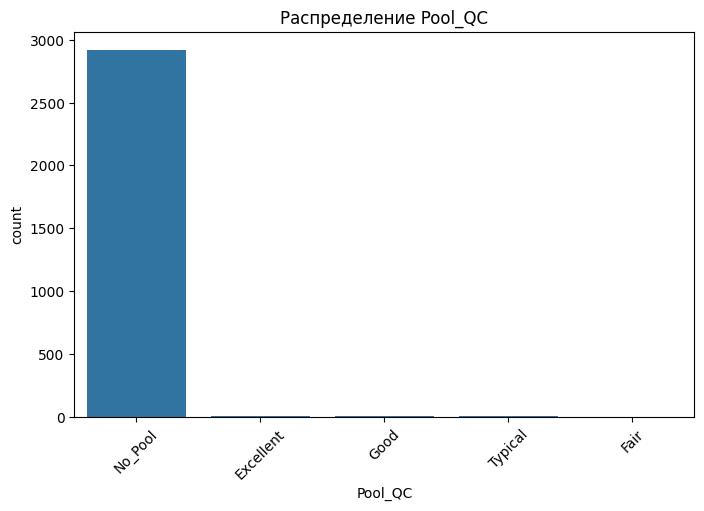


Уникальные значения в Fence:
Fence
No_Fence             2358
Minimum_Privacy       330
Good_Privacy          118
Good_Wood             112
Minimum_Wood_Wire      12
Name: count, dtype: int64


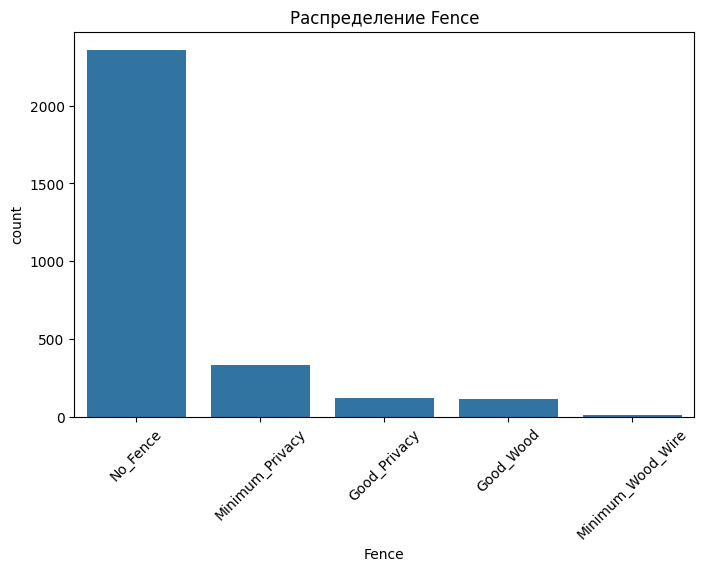


Уникальные значения в Misc_Feature:
Misc_Feature
Shed    2919
Gar2       5
Othr       4
Elev       1
TenC       1
Name: count, dtype: int64


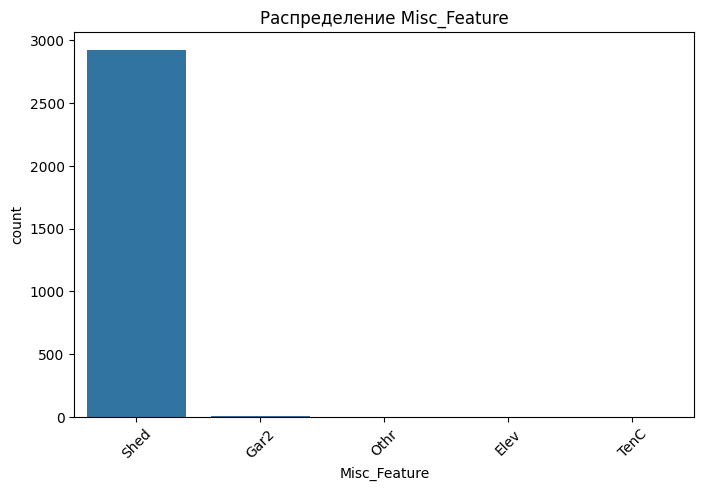


Уникальные значения в Sale_Type:
Sale_Type
WD       2536
New       239
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
VWD         1
Name: count, dtype: int64


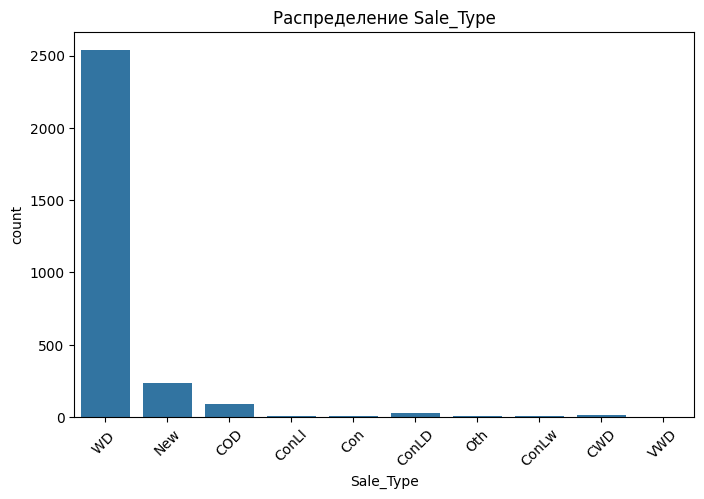


Уникальные значения в Sale_Condition:
Sale_Condition
Normal     2413
Partial     245
Abnorml     190
Family       46
Alloca       24
AdjLand      12
Name: count, dtype: int64


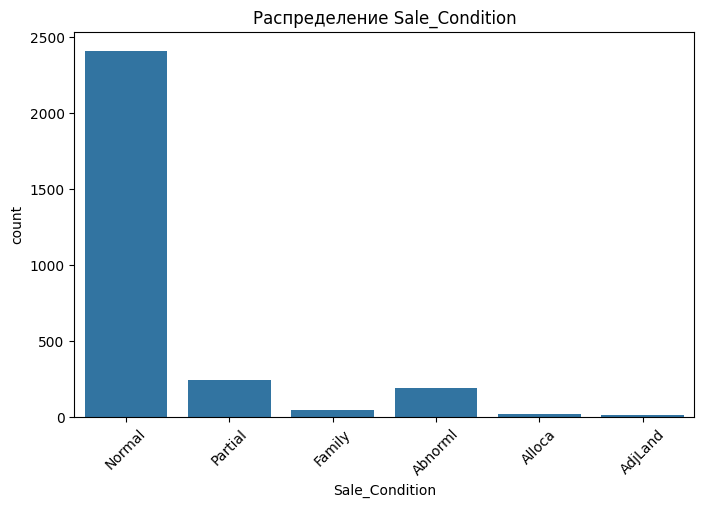

In [ ]:
# Анализ категориальных признаков
# Частотный анализ категориальных признаков
for col in categorical_cols:
    print(f"\nУникальные значения в {col}:")
    print(data[col].value_counts()) # показывает, сколько раз встречается каждое значение.

    plt.figure(figsize=(8, 5))
    sns.countplot(x=col, data=data) # визуализирует частоты в виде столбцов.
    plt.xticks(rotation=45)
    plt.title(f"Распределение {col}")
    plt.show()

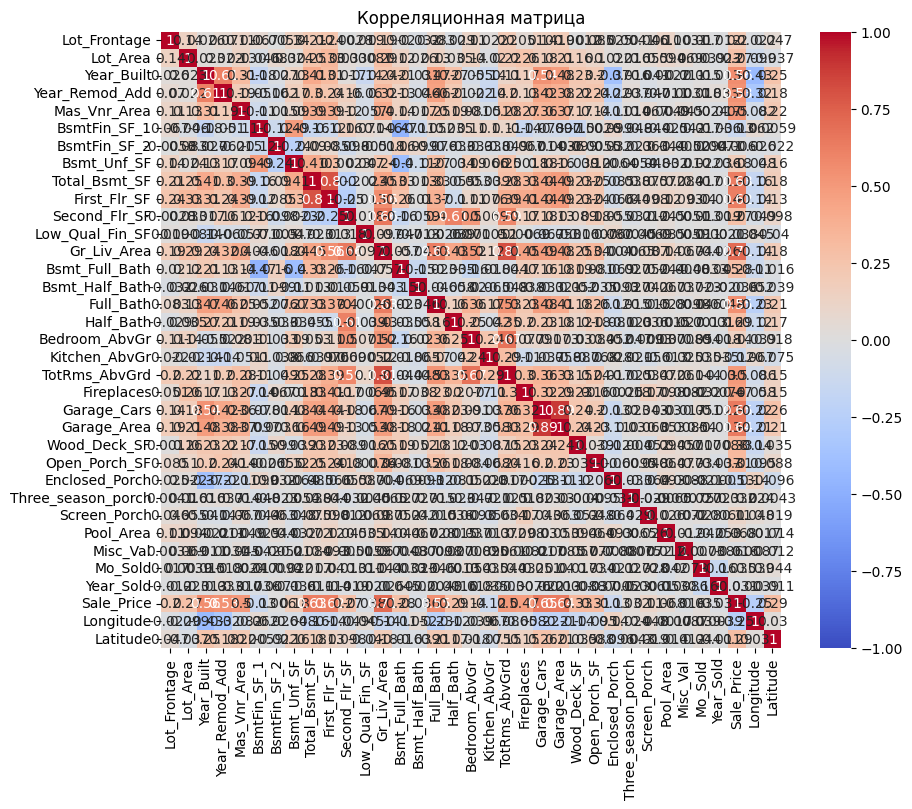

Сильно коррелирующие пары (>0.8): [('Total_Bsmt_SF', 'First_Flr_SF'), ('Gr_Liv_Area', 'TotRms_AbvGrd'), ('Garage_Cars', 'Garage_Area')]


In [ ]:
# Корреляционный анализ

# Корреляционная матрица
corr_matrix = data[numeric_cols].corr() # Корреляция Пирсона измеряет линейную зависимость (от -1 до 1).

# Визуализация
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Корреляционная матрица")
plt.show()

# Вывод сильно коррелирующих пар
threshold = 0.8
high_corr = np.where(np.abs(corr_matrix) > threshold)
high_corr_pairs = [(corr_matrix.index[x], corr_matrix.columns[y])
                   for x, y in zip(*high_corr) if x != y and x < y]
print("Сильно коррелирующие пары (>0.8):", high_corr_pairs)

# Высокая корреляция между признаками (>0.8) может указывать на мультиколлинеарность, что плохо для некоторых моделей (например, линейной регрессии).
# Если есть мультиколлинеарность, можно удалить один из признаков или использовать методы вроде PCA (Метод главных компонент)

Целевая переменная: Latitude


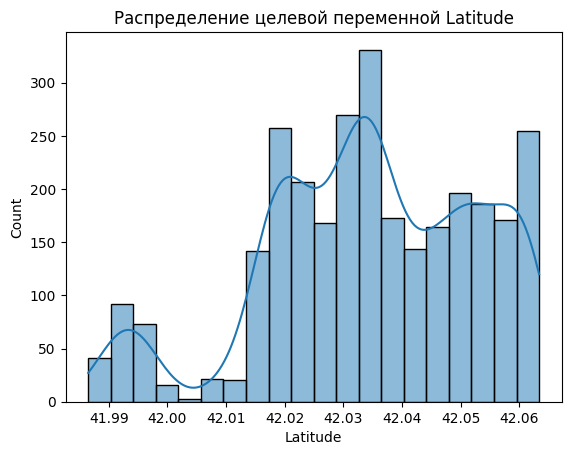

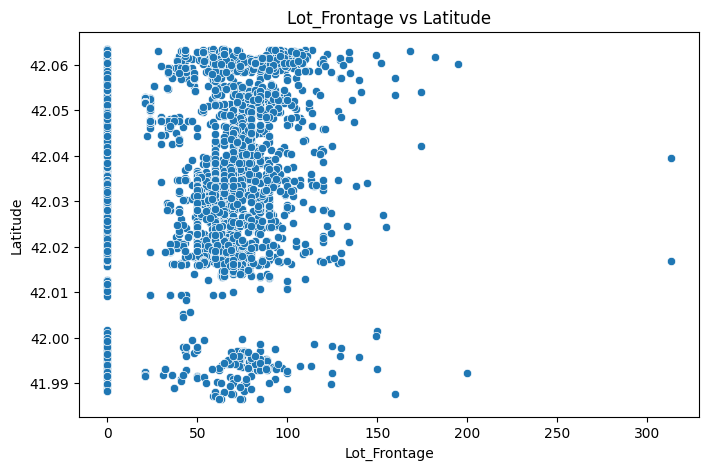

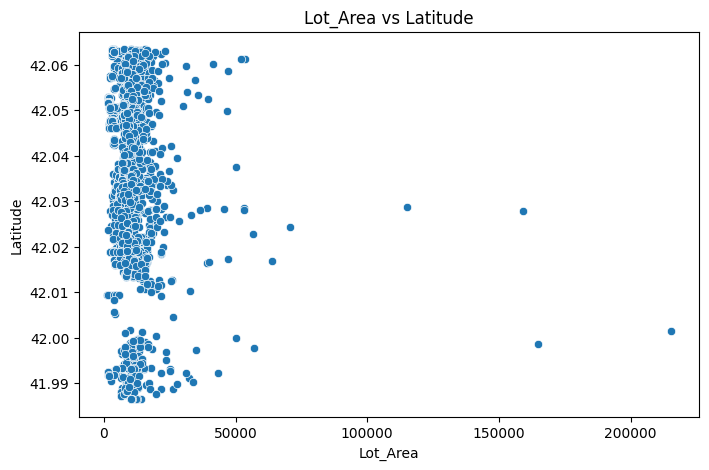

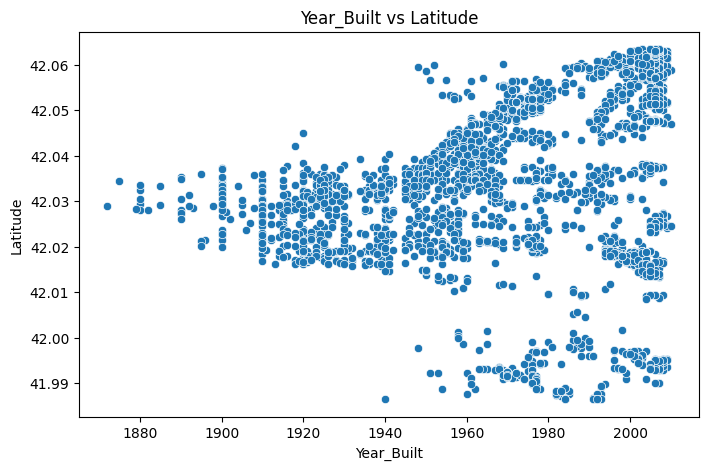

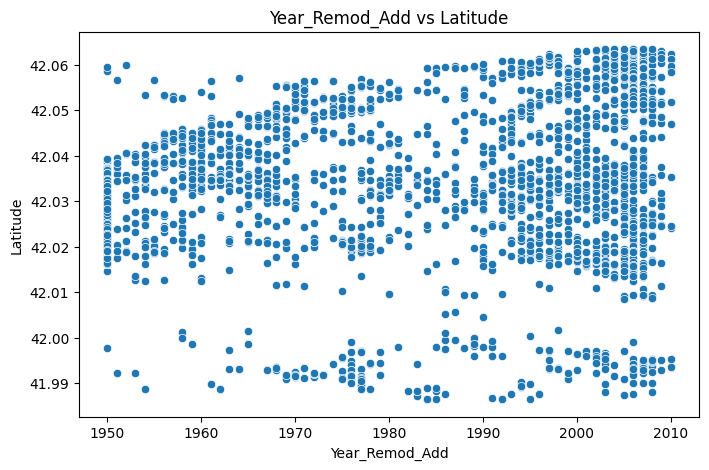

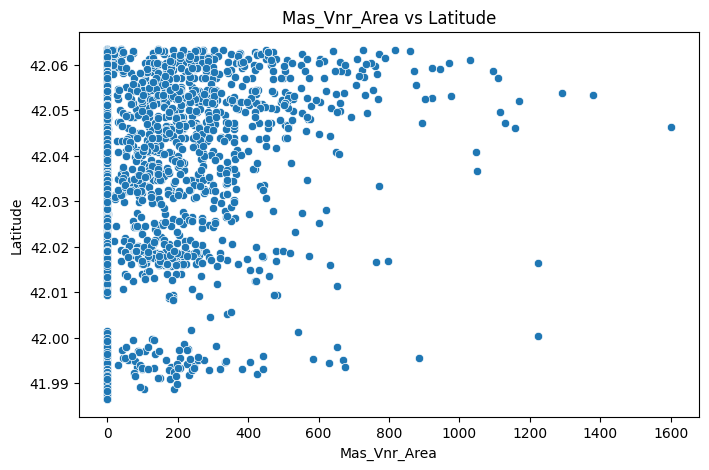

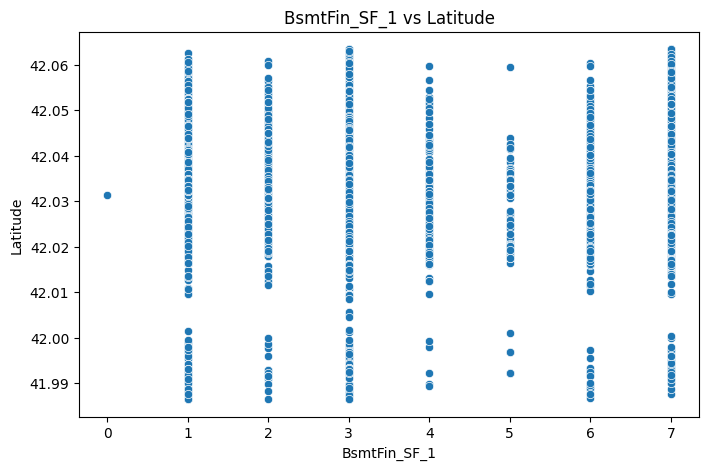

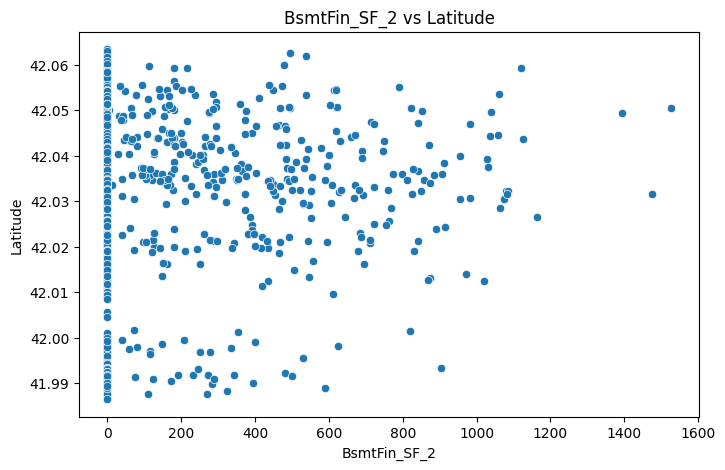

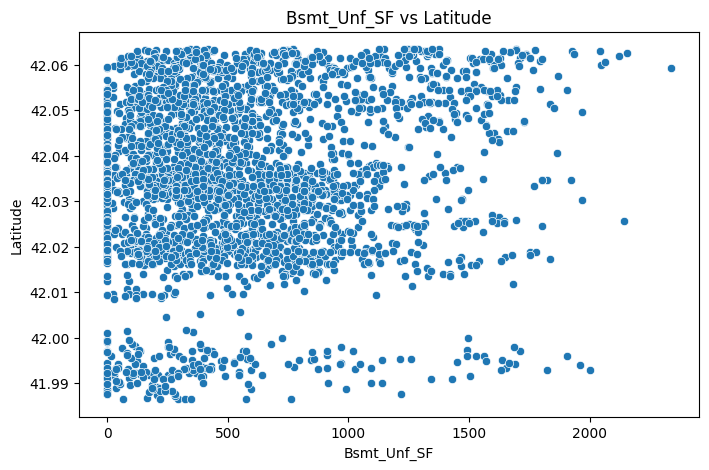

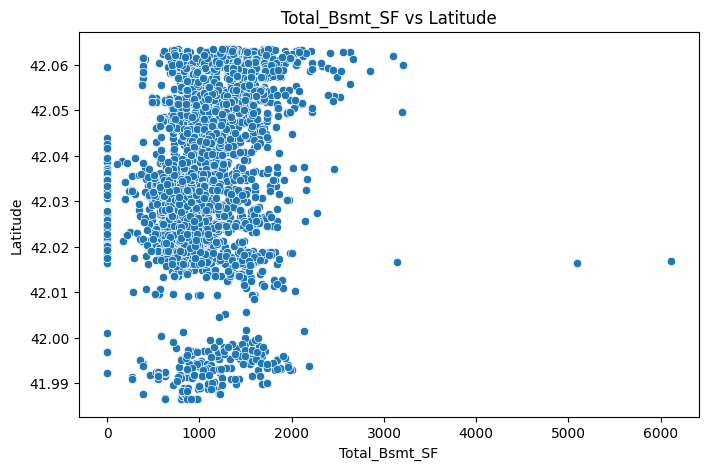

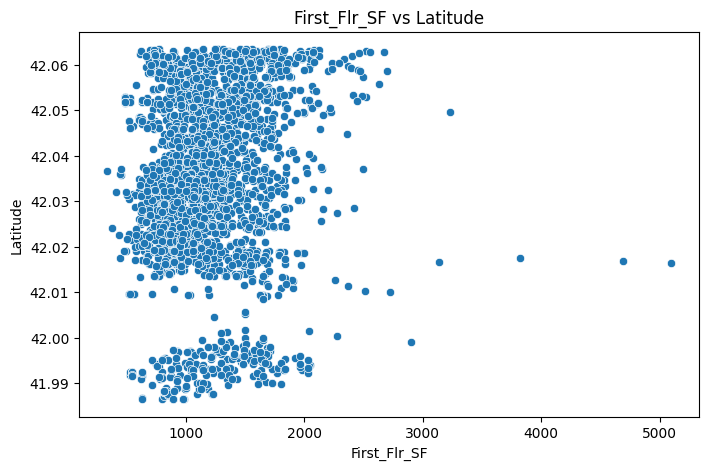

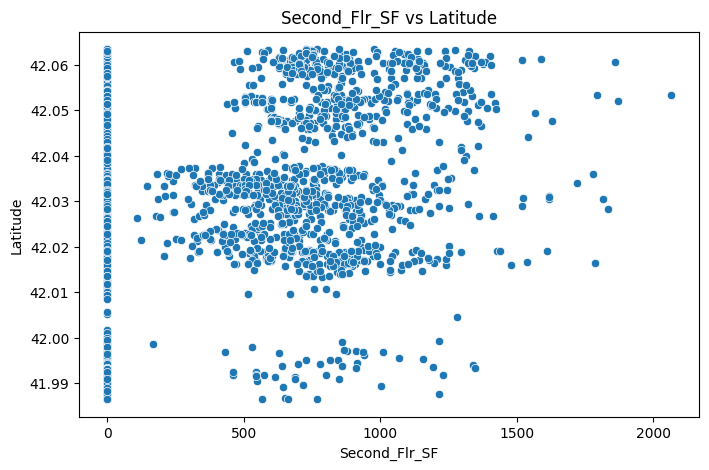

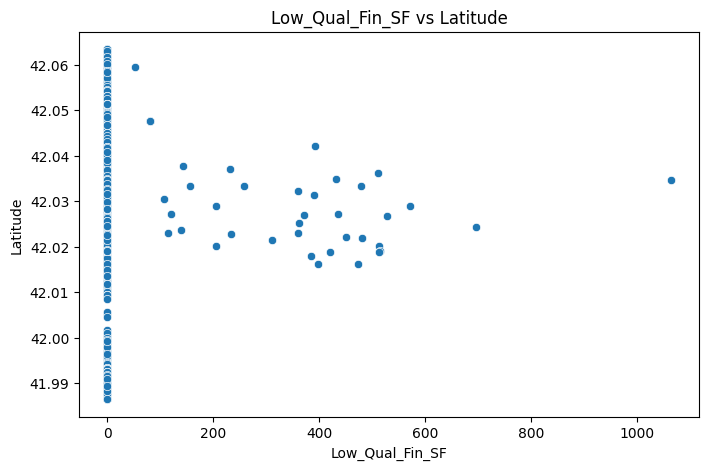

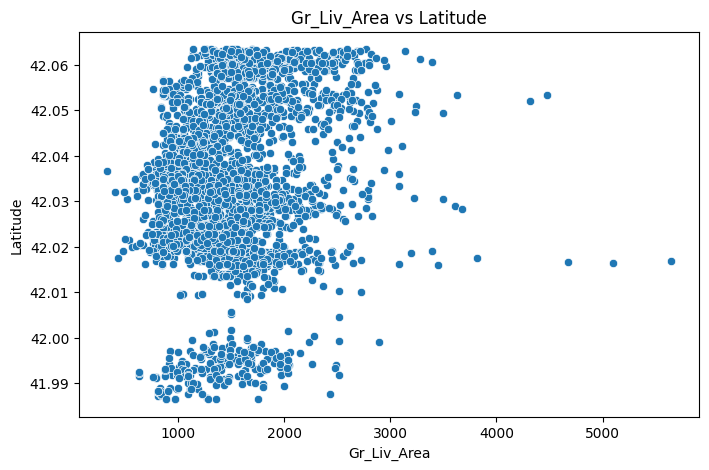

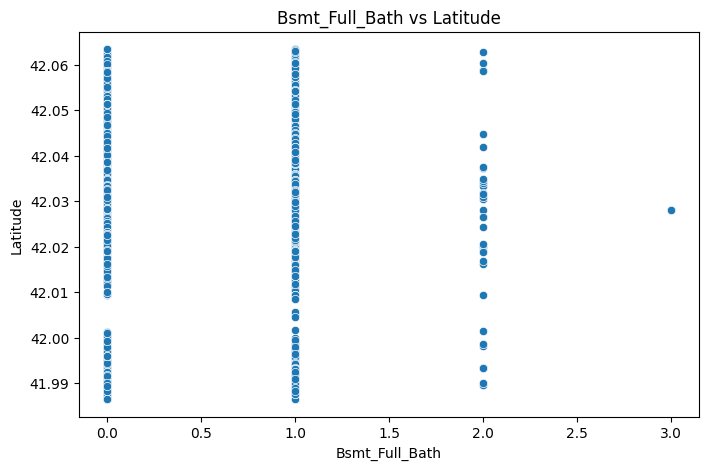

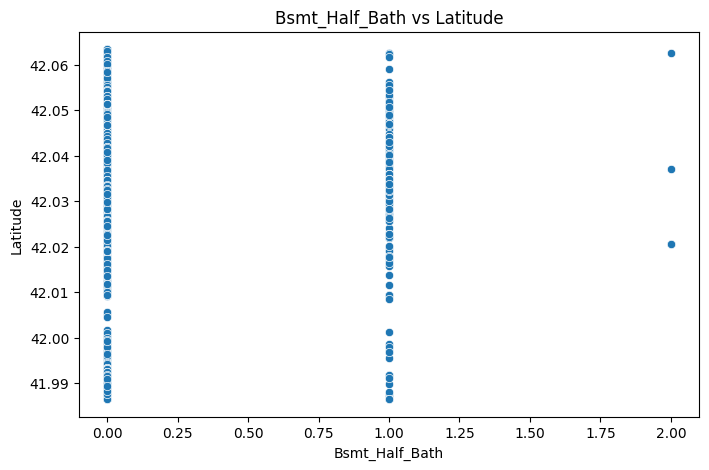

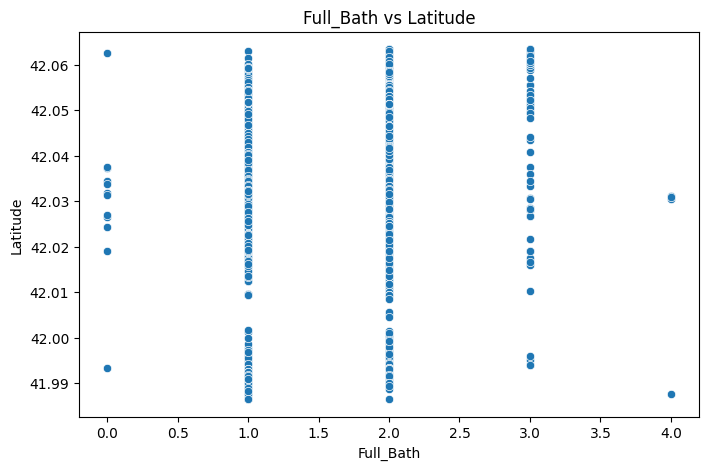

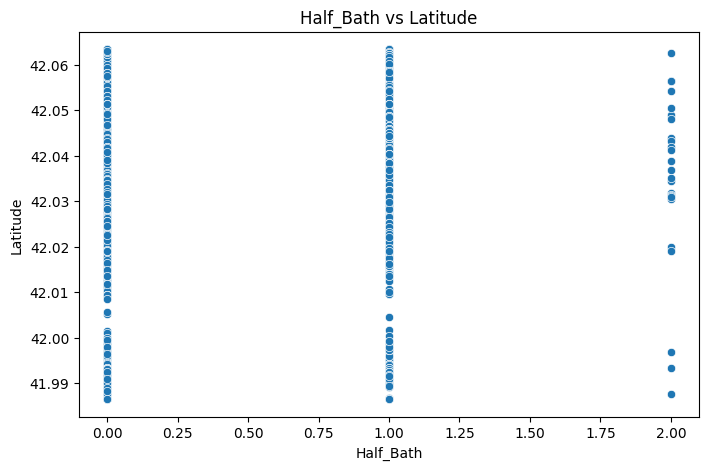

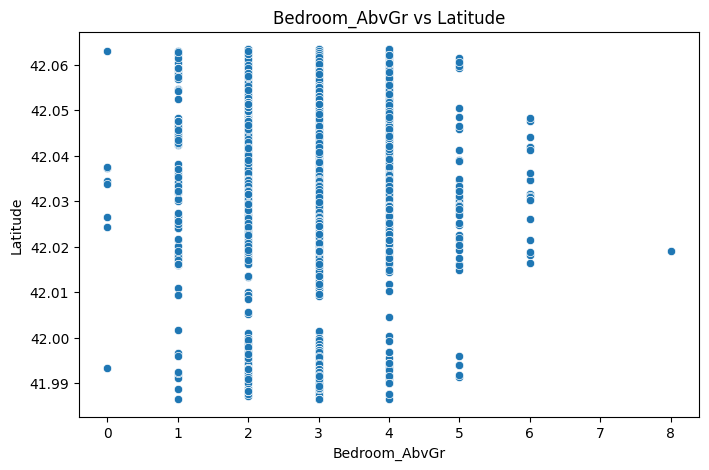

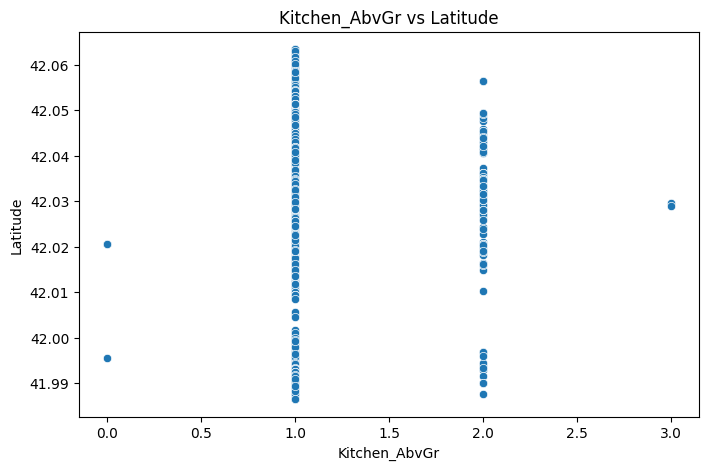

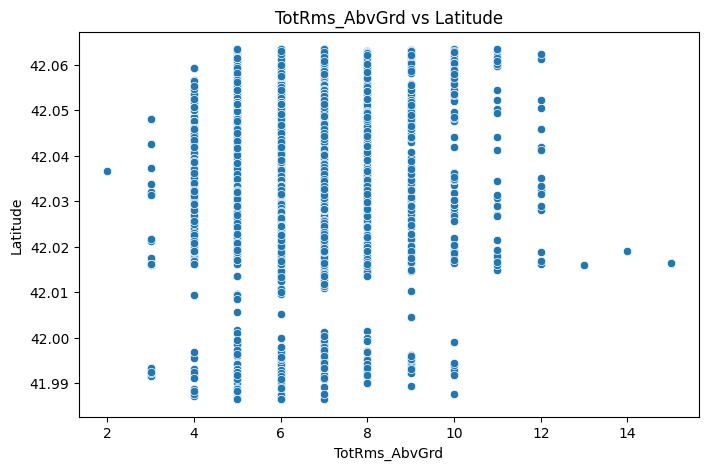

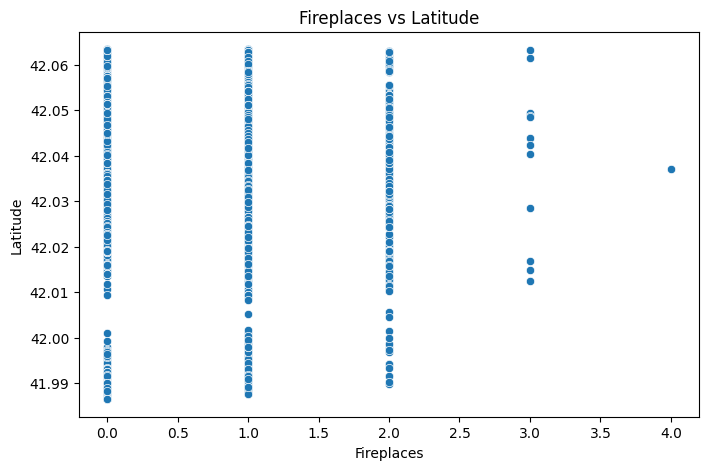

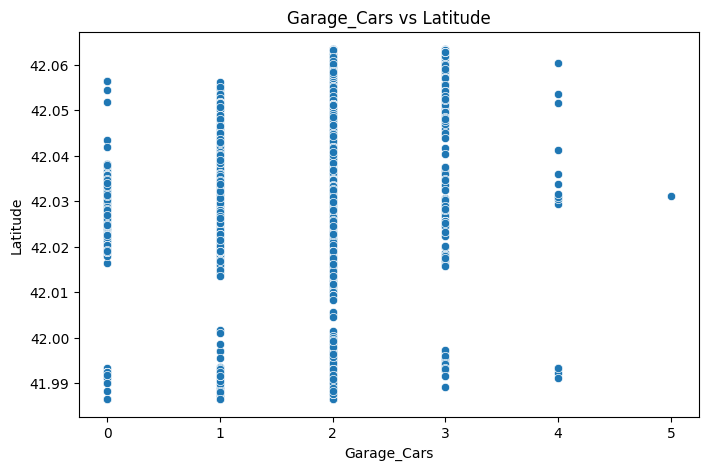

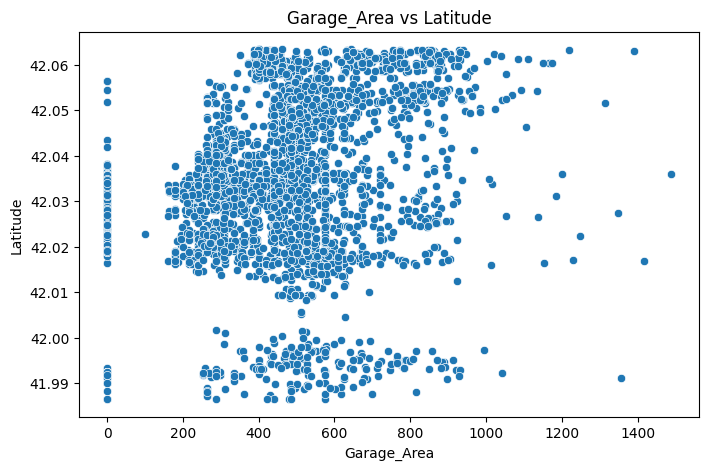

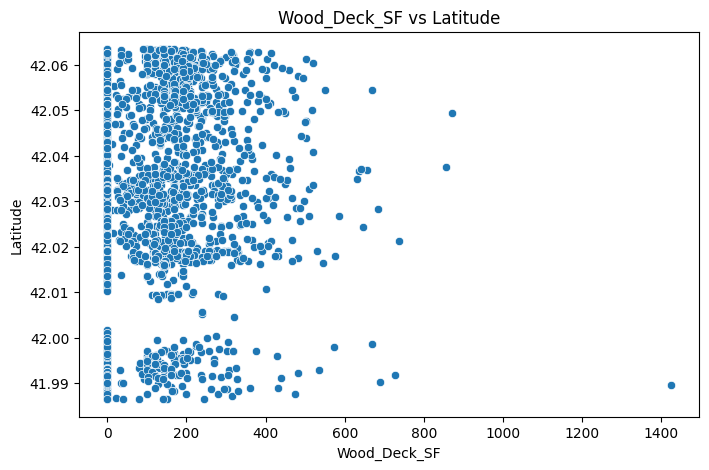

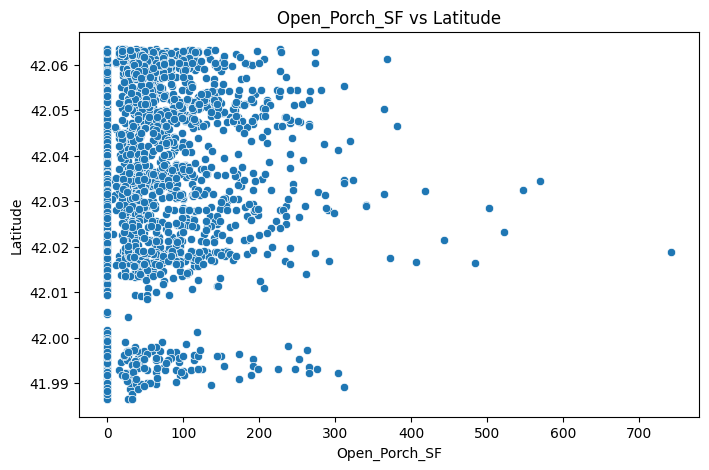

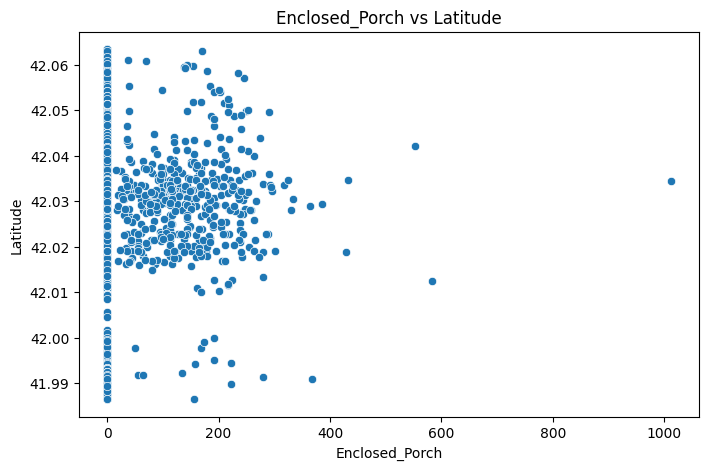

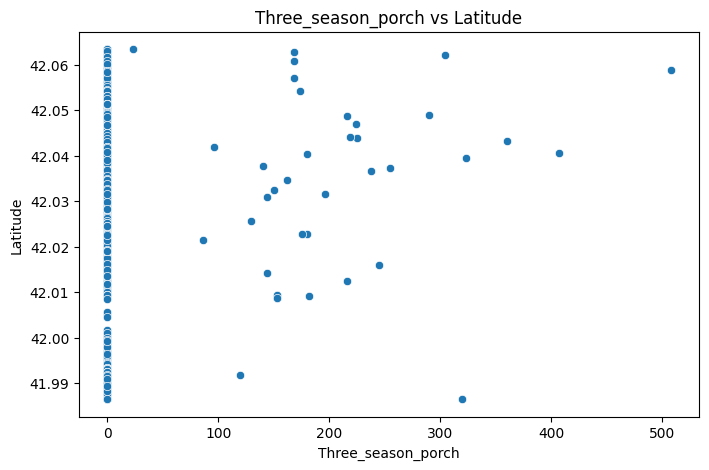

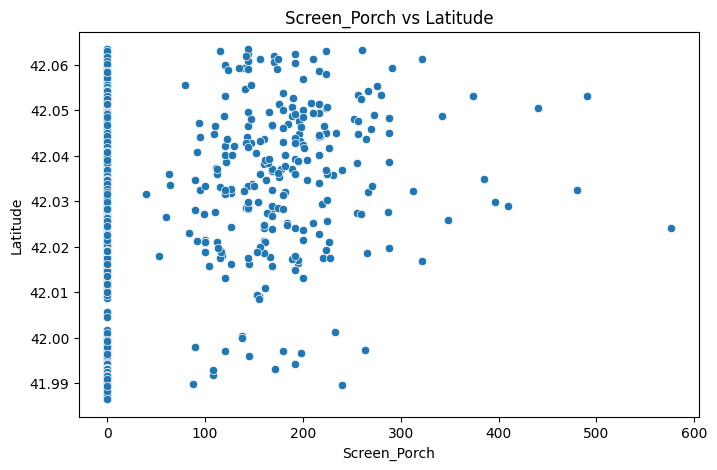

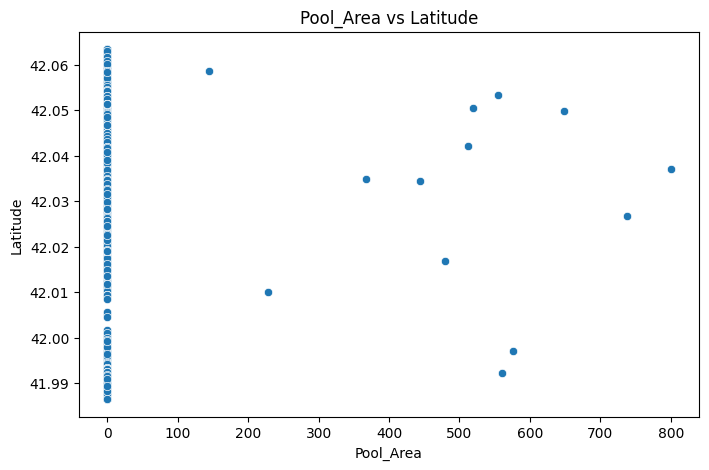

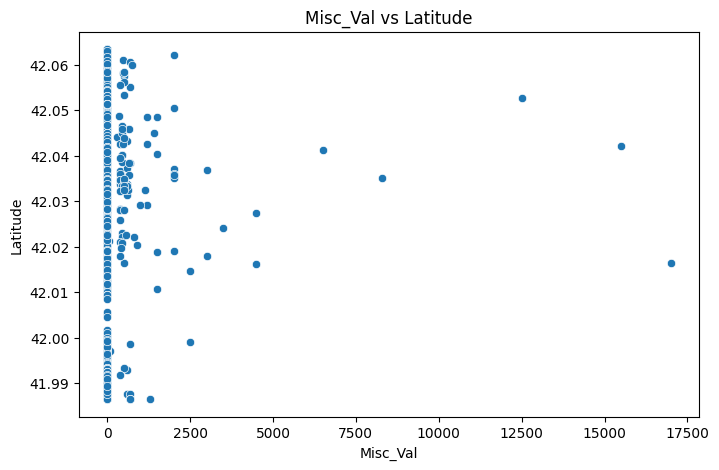

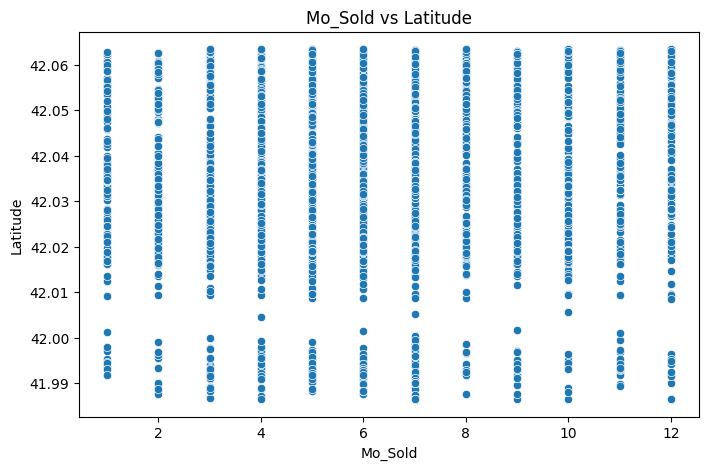

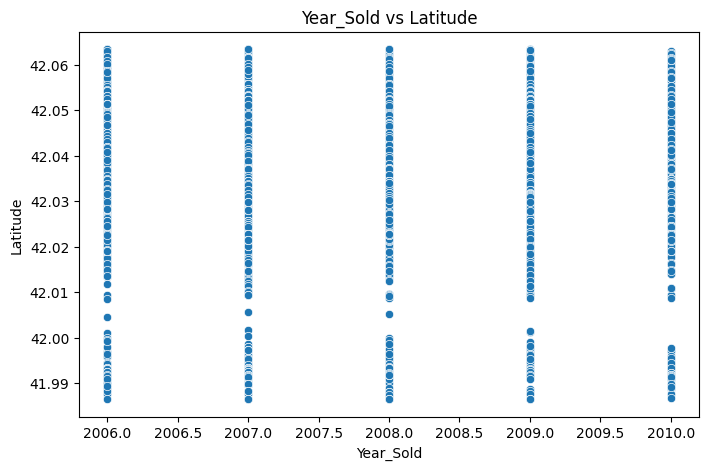

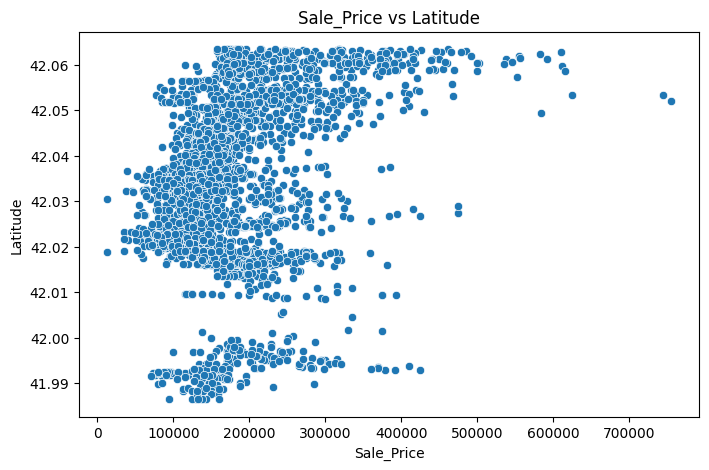

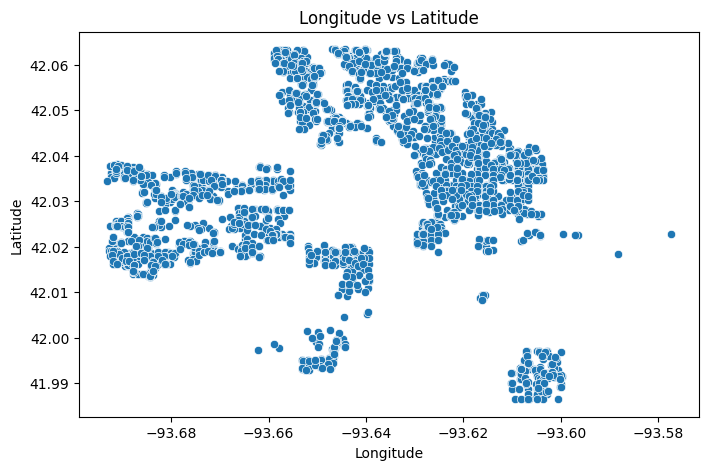

In [ ]:
# Анализ целевой переменной

target = data.columns[-1] # предположим, что последний столбец - это целевая переменна, которую нужно предсказать
print(f"Целевая переменная: {target}")

if data[target].dtype in ['float64', 'int64']:
    # Регрессия
    sns.histplot(data[target], kde=True)
    plt.title(f"Распределение целевой переменной {target}")
    plt.show()
else:
    # Классификация
    sns.countplot(x=target, data=data)
    plt.title(f"Распределение классов в {target}")
    plt.show()

# Зависимость целевой переменной от признаков
for col in numeric_cols:
    if col != target:
        plt.figure(figsize=(8, 5))
        sns.scatterplot(x=col, y=target, data=data)
        plt.title(f"{col} vs {target}")
        plt.show()


# Для регрессии смотрим распределение, для классификации — баланс классов.
# Диаграммы рассеяния помогают увидеть зависимости.

In [ ]:
# Выводы и подготовка данных


# Пропуски: Обработаны медианой и модой.
# Распределения: Если есть скошенные признаки, можно применить np.log1p для нормализации.
# Выбросы: Если их много, можно ограничить значения.
# Корреляции: Удалить один из парного набора, если мультиколлинеарность.
# Категории: Закодировать с помощью One-Hot Encoding или Label Encoding.

# Логарифмирование скошенных признаков
for col in numeric_cols:
    if data[col].skew() > 1:
        data[col] = np.log1p(data[col]) # логарифм для положительных значений.

# Кодирование категориальных признаков
df_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True) #преобразует категории в бинарные столбцы

# Стандартизация числовых признаков
scaler = StandardScaler() # приводит признаки к нулевому среднему и единичной дисперсии.
df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])

print("Первые 5 строк подготовленных данных:")
print(df_encoded.head())

Первые 5 строк подготовленных данных:
   Lot_Frontage  Lot_Area  Year_Built  Year_Remod_Add  Mas_Vnr_Area  \
0      2.488592  2.493250   -0.375537       -1.163488      1.013354   
1      0.667355  0.525278   -0.342468       -1.115542     -0.791606   
2      0.697212  0.926544   -0.441674       -1.259380      0.999594   
3      1.055488  0.445898   -0.110988       -0.779919     -0.791606   
4      0.488217  0.865665    0.848000        0.658466     -0.791606   

   BsmtFin_SF_1  BsmtFin_SF_2  Bsmt_Unf_SF  Total_Bsmt_SF  First_Flr_SF  ...  \
0     -0.975138     -0.364142    -0.268671       0.215921      1.267350  ...   
1      0.816181      2.279281    -0.657780       0.045442     -0.636658  ...   
2     -1.422968     -0.364142    -0.348313       0.390593      0.585336  ...   
3     -1.422968     -0.364142     1.105726       0.779876      2.018621  ...   
4     -0.527308     -0.364142    -0.960420       0.088234     -0.527907  ...   

   Sale_Type_ConLw  Sale_Type_New  Sale_Type_Oth  Sale

Разобьём данные на обучающую и тестовую выборки.

In [ ]:
target_column = "Sale_Price"
np.random.seed(seed)

test_size = 0.2
data_train, data_test, Y_train, Y_test = train_test_split(
    data[data.columns.drop("Sale_Price")],
    np.array(data["Sale_Price"]),
    test_size=test_size,
    random_state=seed)

print(f"Train : {data_train.shape} {Y_train.shape}")
print(f"Test : {data_test.shape} {Y_test.shape}")

Train : (2344, 80) (2344,)
Test : (586, 80) (586,)


Среди признаков нам встретятся как вещественные, так и категориальные. Пока что выделим в качестве категориальных те, значениями которых являются не числа, а какие-то другие сущности (но имейте в виду, что численные с виду признаки тоже могут быть категориальными).

<p>
<details>

**Категориальные признаки** Дискретные значения, которые представляют собой категории или классы. Эти значения могут быть строками или числами, но они не имеют количественного смысла.

Пример: Пол (мужской, женский), тип автомобиля (седан, внедорожник), цвет (красный, синий, зеленый).

**Вещественные признаки** Числовые значения, которые могут быть представлены в виде вещественных чисел (например, 1.23, 45.6) или целых чисел.

Пример: Возраст, рост, вес, цена.
</details>


In [ ]:
continuous_columns = [key for key in data.keys() if data[key].dtype in ("int64", "float64")]
categorical_columns = [key for key in data.keys() if data[key].dtype == "object"]
continuous_columns.remove(target_column)

print(f"Continuous : {len(continuous_columns)}, Categorical : {len(categorical_columns)}")

Continuous : 34, Categorical : 46


Посмотрим на заголовки признаков. В целом, многие названия вполне говорящие, и можно догадаться, что стоит за этими признаками.

In [ ]:
continuous_columns

['Lot_Frontage',
 'Lot_Area',
 'Year_Built',
 'Year_Remod_Add',
 'Mas_Vnr_Area',
 'BsmtFin_SF_1',
 'BsmtFin_SF_2',
 'Bsmt_Unf_SF',
 'Total_Bsmt_SF',
 'First_Flr_SF',
 'Second_Flr_SF',
 'Low_Qual_Fin_SF',
 'Gr_Liv_Area',
 'Bsmt_Full_Bath',
 'Bsmt_Half_Bath',
 'Full_Bath',
 'Half_Bath',
 'Bedroom_AbvGr',
 'Kitchen_AbvGr',
 'TotRms_AbvGrd',
 'Fireplaces',
 'Garage_Cars',
 'Garage_Area',
 'Wood_Deck_SF',
 'Open_Porch_SF',
 'Enclosed_Porch',
 'Three_season_porch',
 'Screen_Porch',
 'Pool_Area',
 'Misc_Val',
 'Mo_Sold',
 'Year_Sold',
 'Longitude',
 'Latitude']

Одна из целей этого ноутбука — познакомить вас с fit-predict (fit-transform) интерфейсом, типичным для многих реализаций моделей машинного обучения и для различных инструментов работы с данными.

Множество фреймворков машинного обучения (например, scikit-learn, CatBoost) содержат в себе модели и алгоритмы, которые описаны в виде классов, у которых есть два ключевых метода: fit и predict (transform). Давайте разберёмся, что делают эти методы.

***fit*** — метод для обучения алгоритма. Он получает на входе данные и таргеты для обучения, после чего обновляет состояние класса. После использования метода fit считается, что объект класса готов к использованию. Внутри этого метода может быть что угодно: обучение модели, подбор гиперпараметров, подсчет статистик и т. д.

***predict*** — метод для предсказания , обученного с помощью _fit_. В задаче регрессии это оценка параметра, в задаче классификации предсказанный класс.

***transform*** — стилистический синоним _predict_, но используется в классах, которые реализуют преобразования данных, например, масштабирование признаков или кодирование категориальных фичей.

***fit_transform*** — метод который учится на данных, а потом их же преобразовывает.

### 1. Базовая предобработка данных

Отметим два важных свойства линейной регрессии:

- строго говоря, она умеет работать только с вещественными признаками
- если признаки имеют разный масштаб при сопоставимой важности, регрессия может проигнорировать те, что имеют меньший масштаб

Первое соображение заставляет придумывать способы борьбы с категориальными признаками, и мы начнём с самого простого: проигнорируем их.

Второе соображение приводит к необходимости приводить признаки к одному масштабу ("нормализовать фичи"). В `sklearn` для этого есть два основных класса:

- [sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) - в каждой колонке вычитает среднее и делит на стандартное отклонение.
- [sklearn.preprocessing.MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) - в каждой колонке вычитает минимальное значение и делит на разницу между минимальным и максимальным.

Применяются они в соответствии с описанной выше философией. Например:

```
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
```

Обратите внимание, что scaler настраивается на обучающей выборке (именно по ней вычисляются среднее и стандартное отклонение), а к тестовой он применяется с уже подсчитанными статистиками.

**Вопрос**. А зачем? Почему бы не нормировать отдельно обучающую и тестовую выборку? Почему бы не настроить наш scaler на объединении двух выборок? Ведь благодаря большему количеству данных мы бы настроили его точнее!
<p>
<details>
  <summary>Кликните, чтобы узнать ответ</summary>

Если мы по-разному отнормируем обучающую и тестовую выборки, то нам будет весьма сложно применять модель, обученную на одной из них, к другой. Это просто не будет иметь физического смысла.

Настраивать что-либо на тестовой выборке — это очень плохая идея. Тестовая выборка должна быть неким независимым мерилом качества наших усилий по предсказанию, а если мы разрешим информации о распределении признаков в тестовой выборке "протечь" в процесс обучения, то мы эту независимость испортим.

</details>

Итак, мы решили делать преобразование данных, которое состоит в:

- сохранении лишь непрерывных фичей;
- нормализации этих фичей (давайте остановимся на [sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html))

В этом пункте вам нужно будет сделать класс такой предобработки данных, причём оформим мы его в виде класса с интерфейсом fit-transform.

Несколько важных соображений:

1. Метод fit должен возвращать сам класс. В частности, это позволит нам писать model = model.fit().

2. Первоначальный анализ данных удобно делать, когда они лежат в pd.DataFrame, т. к. у этого класса много методов, которые малым количеством телодвижений позволяют считать статистики и строить графики. Модели же проще учить, когда данные лежат в np.array, потому большое количество библиотек, где реализованы алгоритмы машинного обучения совместимы именно с numpy. Поэтому сделайте так, чтобы метод transform получал на вход pd.Dataframe, а возвращал np.array.

3. В sklearn есть классы, от которых можно отнаследоваться, чтобы сделать класс с [fit-predict](https://scikit-learn.org/stable/modules/generated/sklearn.base.RegressorMixin.html#sklearn.base.RegressorMixin) или [fit-transform](https://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html) интерфейсом. Это очень полезно, т к позволит вам в дальнейшем пользоваться методами [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) и подобными. В этом пункте отнаследуйтесь от второго.

4. У метода __init__ должен быть параметр ```needed_columns=None```. Туда передается список колонок, которые нужно взять из датафрейма. Делать это надо в ```fit``` и ```transform```. В случае если если он равен None, то класс оставляет все колонки из исходного набора данных.

5. Обратите внимание, что достаточно реализовать `fit` и `transform`, а метод `fit_transform` из них слепит родительский класс.

In [ ]:
class BaseDataPreprocessor():
    def __init__(self, needed_columns: Optional[List[str]]=None):
        """
        :param needed_columns: if not None select these columns from the dataframe
        """
        self.needed_columns = needed_columns
        self.scaler = StandardScaler()
        self.columns_to_use = None


    def fit(self, data, *args):
        """
        Prepares the class for future transformations
        :param data: pd.DataFrame with all available columns
        :return: self
        """
        if self.needed_columns is None:
            self.columns_to_use = data.columns
        else:
            self.columns_to_use = self.needed_columns
        # Оставляем только непрерывные фичи (числовые колонки)
        self.columns_to_use = data[self.columns_to_use].select_dtypes(include=[np.number]).columns

        # Обучаем StandardScaler на выбранных колонках
        self.scaler.fit(data[self.columns_to_use])

        # Возвращаем self для поддержки цепочки вызовов
        return self


    def transform(self, data: pd.DataFrame) -> np.array:
        """
        Transforms features so that they can be fed into the regressors
        :param data: pd.DataFrame with all available columns
        :return: np.array with preprocessed features
        """
        # Применяем StandardScaler к выбранным колонкам
        transformed_data = self.scaler.transform(data[self.columns_to_use])

        # Возвращаем результат в виде np.array
        return transformed_data

    def fit_transform(self, data: pd.DataFrame, *args) -> np.array:
        """
        Combines fit and transform methods for convenience
        :param data: pd.DataFrame with all available columns
        :return: np.array with preprocessed features
        """
        self.fit(data)
        return self.transform(data)


**1. Тут нужно позвать препода для начисления поинтов**

In [ ]:
preprocessor = BaseDataPreprocessor(needed_columns=continuous_columns)

X_train = preprocessor.fit_transform(data_train)
X_test = preprocessor.transform(data_test)
print(X_test)
print(X_train)

[[ 0.2531117   0.84551806  1.09413674 ...  0.15915917 -1.85699633
   0.17491808]
 [-1.70505166  0.83296049  0.49060136 ...  0.91897402 -0.06109778
  -1.30850436]
 [ 0.07509685  0.05867517 -1.89001039 ...  0.15915917  0.69506797
  -0.34550822]
 ...
 [ 0.66847969  0.80077119 -0.07940427 ... -1.36047053  1.67720305
  -2.34193166]
 [ 0.37178827 -0.10663638  0.28942291 ...  1.67878887 -1.63270955
   0.00413614]
 [ 0.16410428 -0.23235034  1.06060699 ... -1.36047053  0.12096894
   1.39070206]]
[[ 0.72781797  0.43100524  0.65825008 ...  0.91897402  1.59953221
  -2.10399441]
 [ 0.28278084  0.78850683  1.09413674 ...  1.67878887 -0.03026421
   1.46544646]
 [ 0.63881055  0.00817806 -0.4147017  ... -1.36047053  1.4104223
   0.21280896]
 ...
 [ 0.52013398  0.84765051 -0.71646938 ... -0.60065568  0.65006975
  -0.71551757]
 [ 0.22344256  0.40549977 -0.4147017  ...  0.91897402 -0.82561363
  -0.89443458]
 [ 0.22344256 -0.42047725 -0.14646375 ...  0.91897402  0.69254025
   0.78026581]]


### 1.2 Умная предобработка данных

Теперь давайте попробуем сделать что-нибудь поинтереснее. Для того, чтобы будущие алгоритмы регрессии работали хорошо, они должны обучаться и предсказывать на информативных фичах. Зачастую оказывается гораздо продуктивнее потратить какое-то время на изучение предметной области и придумывание хороших фичей (feature engineering), нежели жадно перебирать все известные алгоритмы машинного обучения.
В этом пункте попробуйте придумать новых фичей и написать новый класс предобработки данных, который их добавляет (а, возможно, и убирает ещё какие-то старые).

В конце этого пункта в раскрывашке перечислены идеи относительно того, что можно было добавить.

In [ ]:
class SmartDataPreprocessor(TransformerMixin):
    def __init__(self, needed_columns: Optional[List[str]] = None, add_polynomial: bool = True, add_interactions: bool = True):
        """
        :param needed_columns: if not None, select these columns from the dataframe
        :param add_polynomial: if True, add polynomial features
        :param add_interactions: if True, add interaction features
        """
        self.needed_columns = needed_columns
        self.add_polynomial = add_polynomial
        self.add_interactions = add_interactions
        self.scaler = StandardScaler()
        self.poly = PolynomialFeatures(degree=2, include_bias=False)  # Всегда инициализируем
        self.columns_to_use = None

    def fit(self, data: pd.DataFrame, *args):
        """
        Prepares the class for future transformations
        :param data: pd.DataFrame with all available columns
        :return: self
        """
        # Если needed_columns не задан, используем все колонки
        if self.needed_columns is None:
            self.columns_to_use = data.columns
        else:
            self.columns_to_use = self.needed_columns

        # Оставляем только непрерывные фичи (числовые колонки)
        self.columns_to_use = data[self.columns_to_use].select_dtypes(include=[np.number]).columns

        # Обучаем StandardScaler на выбранных колонках
        self.scaler.fit(data[self.columns_to_use])

        # Обучаем PolynomialFeatures (если нужно)
        if self.add_polynomial:
            self.poly.fit(self.scaler.transform(data[self.columns_to_use]))

        return self

    def transform(self, data: pd.DataFrame) -> np.array:
        """
        Transforms features by adding new engineered features
        :param data: pd.DataFrame with all available columns
        :return: np.array with preprocessed features
        """
        # Применяем StandardScaler к выбранным колонкам
        scaled_data = self.scaler.transform(data[self.columns_to_use])
        scaled_df = pd.DataFrame(scaled_data, columns=self.columns_to_use)

        # Добавляем полиномиальные фичи (если нужно)
        if self.add_polynomial:
            poly_features = self.poly.transform(scaled_df)
            poly_columns = self.poly.get_feature_names_out(scaled_df.columns)
            poly_df = pd.DataFrame(poly_features, columns=poly_columns)
            scaled_df = pd.concat([scaled_df, poly_df], axis=1)

        # Добавляем фичи взаимодействия (если нужно)
        if self.add_interactions:
            for i, col1 in enumerate(scaled_df.columns):
                for col2 in scaled_df.columns[i + 1:]:
                    # Добавляем фичу взаимодействия по одной
                    scaled_df[f"{col1}_x_{col2}"] = scaled_df[col1] * scaled_df[col2]

        # Возвращаем результат в виде np.array
        return scaled_df.values

In [ ]:
preprocessor = SmartDataPreprocessor(needed_columns=continuous_columns)

X_train = preprocessor.fit_transform(data_train)
X_test = preprocessor.transform(data_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


ValueError: Cannot set a DataFrame with multiple columns to the single column Lot_Frontage_x_Lot_Area

<details>
  <summary>Пара простых идей. Кликните, когда будете готовы</summary>

Например в датасете есть координаты квартиры, которые по идее сами по себе мало чего дают нашему регрессору. С другой стороны, по ним можно оценить центр города (или просто найти его на карте) и использовать в качестве фичи расстояние до центра города, которое может естественным образом влиять на цену жилья.

Ещё может быть полезным почистить пропуски. И тут есть хитрость. Если вы просто вызовете data.info(), то вам покажется, что пропусков нет, но они могут приходить под разными обличьями. Например, у 490 объектов параметр Lot_Frontage (площадь фасада) равен нулю. Неожиданно, правда? Возможно, мы хотим эти нулевые значения заменить чем-нибудь, скажем, медианой.

</details>


### 2. Линейная регрессия

Давайте получим базовое решение (бейзлайн), чтобы потом с ним можно было сравниваться.

Обучите линейную регрессию на обучающей выборке (которую мы подвергли преобразованию BaseDataPreprocessor). В библиотеке Sklearn есть релизация [без регуляризации](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html?highlight=linear%20regression), [с L2-регуляризацией](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge) и [с L1-регуляризацией](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso).

Начнём с обычной регрессии. Получите предсказания на тестовых данных и оцените на них качество модели. В качестве метрики оценки качества возьмите [средний модуль отклонения](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html) (mean absolute error, MAE). Как вам кажется, насколько хорошей вышла модель?


In [ ]:
## # 1. Предобработка данных
# Предположим, что у нас уже есть preprocessor, обученный на train данных
X_train = preprocessor.fit_transform(data_train)
X_test = preprocessor.transform(data_test)

# 2. Обучение модели
# Создаем модель линейной регрессии
model = LinearRegression()

# Обучаем модель на обучающих данных
model.fit(X_train, Y_train)

# 3. Предсказание и оценка качества
# Получаем предсказания на тестовой выборке
y_pred = model.predict(X_test)

# Оцениваем качество модели с помощью MAE
mae = mean_absolute_error(Y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 0.1118394168478599


Теперь попробуйте L2-регуляризованную модель Ridge(). Какие значения метрик она даёт?

In [ ]:
## # Создаем модель Ridge-регрессии
ridge_model = Ridge(alpha=1.0)  # alpha — параметр регуляризации

# Обучаем модель на обучающих данных
ridge_model.fit(X_train, Y_train)

# 3. Предсказание и оценка качества
# Получаем предсказания на тестовой выборке
y_pred_ridge = ridge_model.predict(X_test)

# Оцениваем качество модели с помощью MAE
mae_ridge = mean_absolute_error(Y_test, y_pred_ridge)
print(f"Mean Absolute Error (MAE) для Ridge: {mae_ridge}")

Mean Absolute Error (MAE) для Ridge: 0.111840721904271


В целом, регуляризация редко портит модель, но важно правильно подобрать коэффициент регуляризации. Как именно — поговорим дальше.

**2. Тут нужно позвать препода для начисления поинтов**

### 3. Выбор метрики

Средний модуль ошибки (MAE) — в целом довольно хорошая метрика для задачи регрессии, потому что ее довольно легко проинтерпретировать. Но с ней есть одна проблема: ошибиться на $ 10 000 $ USD в предсказании цены квартиры стоимостью $ 100 000 $ USD страшнее чем допустить такую ошибку в предсказании цены жилья за $ 700 000 $ USD. Иными словами более показательной метрикой будет не абсолютная  ошибка $ error_i = |y_i - \hat{y_i}|$, а логарифм относительной ошибки $error_i = log \frac{y_i}{\hat{y_i}} $. Также давайте обычное усреднение по всем примерам в тестовой выборке заменим на среднеквадратичное $ \frac{1}{N} \sum_i^{test} {error_i} \longrightarrow \sqrt{\frac{1}{N} \sum_i^{test}{(error_i)^2}}$. Итоговая метрика получается равной:

$$
Metric = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (log(y_i) - log(\hat{y_i}))^2}
$$

Логично? Да. Но возникает еще одна проблема. Логарифм нельзя брать от отрицательного числа. Бороться с этим можно двумя способами.
- Случай когда отрицательное число затисалось в target-ax не очень разумен, т. к. цена на дом не может быть отрицательной. В этом случае стоит кинуть ошибку, чтобы пользователь этой функции еще раз перепроверил правильные ли таргеты он подает.
- В целом, у нас нет гарантий того, что наша модель (например линейная) предсказывает только положительные числа. Брать логарифм от отрицательного числа не получится, но качество такой модели все еще надо оценить. Давайте все предсказания, которые меньше некоторого порога $ a_{min} $, заменять этим порогом ($ \hat{y_i} \longleftarrow max(\hat{y_i}, a_{min}) $), после чего подавать их в метрику. Для прохождения тестов возьмите $ a_{min} = 1 $.

**Реализуйте эту метрику**.

In [ ]:
def root_mean_squared_logarithmic_error(y_true, y_pred, a_min=1):
    """
    Вычисляет RMSLE (Root Mean Squared Logarithmic Error) с учетом минимального порога для предсказаний.

    Параметры:
    y_true (array-like): Истинные значения.
    y_pred (array-like): Предсказанные значения.
    a_min (float): Минимальный порог для предсказаний. По умолчанию 1.

    Возвращает:
    float: Значение RMSLE.
    """
    # Преобразуем входные данные в массивы numpy
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # Проверка на отрицательные значения в y_true
    if np.any(y_true < 0):
        raise ValueError("y_true содержит отрицательные значения, что недопустимо для данной метрики.")

    # Заменяем предсказания меньше a_min на a_min
    y_pred = np.maximum(y_pred, a_min)

    # Вычисляем RMSLE
    rmsle = np.sqrt(np.mean((np.log1p(y_true) - np.log1p(y_pred)) ** 2))
    return rmsle

# Пример использования:
y_true = [100, 200, 300]
y_pred = [110, 190, 310]

# Вычисляем RMSLE
rmsle_value = root_mean_squared_logarithmic_error(y_true, y_pred)
print(f"RMSLE: {rmsle_value}")


RMSLE: 0.06477025015968771


### 4. Логарифмирование таргета.

Вообще идея с логарифмированием таргета довольно хороша для этой задачи. Давайте посмотрим на распределение обычных и логарифмированных таргетов.

In [ ]:
def plot_target_distribution(Y_train, Y_test, ax, n_bins=20):
    ax.hist(Y_train, bins=n_bins, label="train", color="red", alpha=0.3, density=True)
    ax.hist(Y_test, bins=n_bins, label="test", color="blue", alpha=0.3, density=True)

    ax.legend()
    ax.set_xlabel("Value")
    ax.set_ylabel("Probability")


def plot_both_distributions(Y_train, Y_test):
    fig, (ax0, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(15, 6))

    plot_target_distribution(Y_train, Y_test, ax=ax0)
    ax0.set_title("Standard")

    plot_target_distribution(np.log(Y_train), np.log(Y_test), ax=ax1)
    ax1.set_title("Logarithmic")

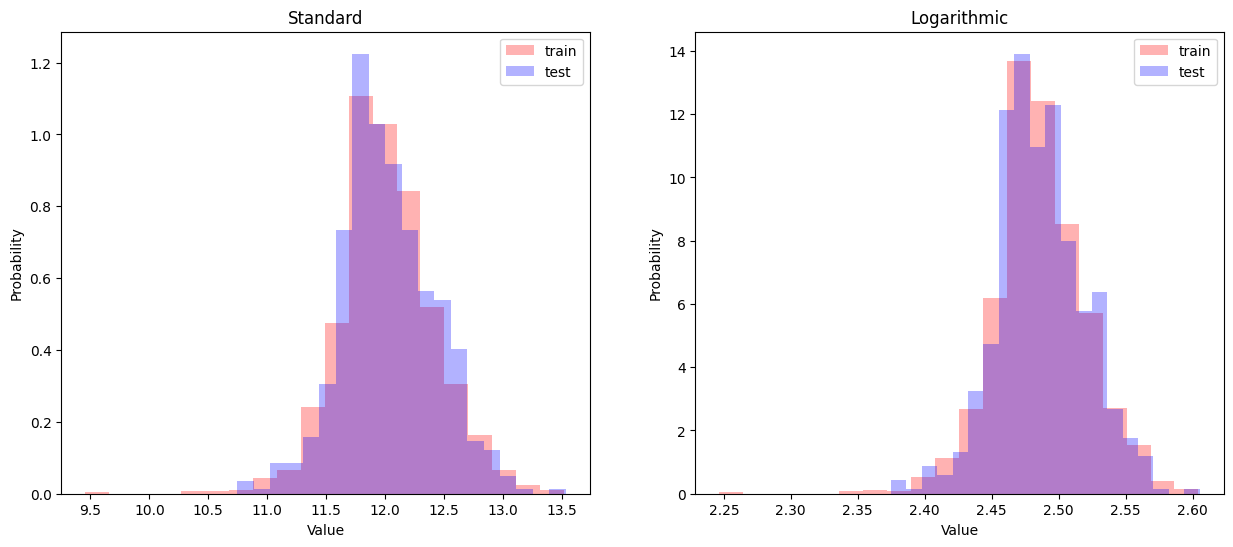

In [ ]:
plot_both_distributions(Y_train, Y_test)

Как видите, если прологарифмировать таргеты, то их распределение станет более похоже на гауссовское. Интуиция подсказывает, что линейная регрессия с MSE loss-функцией должна лучше учиться на таких таргетах.

Попробуйте написать класс, который во время обучения логарифмирует таргет, а во время предсказания — наоборот, экспоненциирует. После чего обучите оба метода на обучающих данных и сравните значения метрик MAE и MSLE на тесте.

Что должно быть в этом классе:
- Класс должен называться ```ExponentialLinearRegression```
- Класс должен иметь такой же fit-predict интерфейс, как и было до этого. На вход он получает оригинальные X и Y, а уже внутри происходит логарифмирование или экспоненциирование.
- Внутри этой модели будет работать [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html). Хочется, чтобы этому классу можно было передавать аргументы инициализации с помощью *args и **kwargs
- Чтобы потом этот класс можно было использовать в [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) в следующих пунктах, у него должны быть реализованы 5 методов
    1. ```__init__(self, *args, **kwargs)``` - все полученные аргументы передаются дальше в Ridge.
    2. ```fit(self, X, Y)``` - обучает класс, возвращает self.
    3. ```predict(self, X)``` - делает предсказание.
    4. ```get_params(deep=True)``` - возвращает dict с параметрами модели. Больще подробностей [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html)
    5. ```set_params(**params)``` - передает нужные параметры в модель. Больше подробносте [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html)
- Есть два подхода к тому как сделать все нужные методы:
    - Отнаследоваться от класса Ridge и переопределить методы fit и predict, внутри вызывая super() от отцовского класса.
    - Отнаследоваться от класса RegressorMixin и внутренним атрибутом класса сделать Ridge. Тогда все методы нужно будет писать руками.

In [ ]:
class ExponentialLinearRegression(BaseEstimator, RegressorMixin):
    """
    Класс, который во время обучения логарифмирует таргет,
    а во время предсказания экспоненциирует результат.
    Использует Ridge как внутреннюю модель.
    """

    def __init__(self, alpha=1.0, fit_intercept=True, copy_X=True, max_iter=None,
                 tol=1e-3, solver='auto', positive=False, random_state=None):
        self.alpha = alpha
        self.fit_intercept = fit_intercept
        self.copy_X = copy_X
        self.max_iter = max_iter
        self.tol = tol
        self.solver = solver
        self.positive = positive
        self.random_state = random_state

        # Создаем внутреннюю модель
        self.model_ = Ridge(
            alpha=self.alpha,
            fit_intercept=self.fit_intercept,
            copy_X=self.copy_X,
            max_iter=self.max_iter,
            tol=self.tol,
            solver=self.solver,
            positive=self.positive,
            random_state=self.random_state
        )

    def fit(self, X, y, sample_weight=None):
        """
        Обучает модель на логарифмированных значениях y.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Обучающие данные
        y : array-like of shape (n_samples,)
            Целевые значения
        sample_weight : array-like of shape (n_samples,), default=None
            Веса для каждого образца

        Returns
        -------
        self : object
            Возвращает self
        """
        # Проверяем, что все значения положительные
        if np.any(y <= 0):
            raise ValueError("Все значения y должны быть положительными")

        # Логарифмируем y
        y_log = np.log(y)

        # Обучаем внутреннюю модель
        self.model_.fit(X, y_log, sample_weight)
        return self

    def predict(self, X):
        """
        Делает предсказание и экспоненциирует результат.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Данные для предсказания

        Returns
        -------
        y : array-like of shape (n_samples,)
            Предсказанные значения
        """
        # Получаем предсказания в логарифмическом масштабе
        y_log = self.model_.predict(X)

        # Экспоненциируем результат
        return np.exp(y_log)

    def get_params(self, deep=True):
        """
        Получает параметры модели.

        Parameters
        ----------
        deep : bool, default=True
            Если True, вернет параметры для этого класса и подобъектов.

        Returns
        -------
        params : dict
            Параметры модели
        """
        return {
            'alpha': self.alpha,
            'fit_intercept': self.fit_intercept,
            'copy_X': self.copy_X,
            'max_iter': self.max_iter,
            'tol': self.tol,
            'solver': self.solver,
            'positive': self.positive,
            'random_state': self.random_state
        }

    def set_params(self, **params):
        """
        Устанавливает параметры модели.

        Parameters
        ----------
        **params : dict
            Параметры для установки

        Returns
        -------
        self : object
            Возвращает self
        """
        for key, value in params.items():
            setattr(self, key, value)

        # Обновляем внутреннюю модель с новыми параметрами
        self.model_ = Ridge(
            alpha=self.alpha,
            fit_intercept=self.fit_intercept,
            copy_X=self.copy_X,
            max_iter=self.max_iter,
            tol=self.tol,
            solver=self.solver,
            positive=self.positive,
            random_state=self.random_state
        )
        return self

**3. Тут нужно позвать препода для получения поинтов**.

In [ ]:
classic_regressor = Ridge()
exponential_regressor = ExponentialLinearRegression()

classic_regressor.fit(X_train, X_train)
exponential_regressor.fit(X_train, X_train)

classic_prediction = classic_regressor.predict(X_test)
exponential_prediction = exponential_regressor.predict(X_test)

print(f"MAE  : Classic : {mean_absolute_error(X_test, classic_prediction)}  Exponential : {mean_absolute_error(X_test, exponential_prediction)}")
print(f"MSLE : Classic : {root_mean_squared_logarithmic_error(X_test, classic_prediction)} Exponential : {root_mean_squared_logarithmic_error(X_test, exponential_prediction)}")

MAE  : Classic : 0.12820512820512775  Exponential : 0.24159227328121036
MSLE : Classic : 0.04184710993550045 Exponential : 0.083958686025142


Иногда получается так, что разные обученные вами модели приводят к улучшению одних метрик и ухудшению других. Это абсолютно нормально и этому не надо удивляться.

Также зачастую случается так, что прирост по метрике не очень большой. И вы можете захотеть убедиться, что это реальное улучшение, а не просто случайная флуктуация. Для этого можно использовать подсчёт метрики про кросс-валидации (подробнее о ней можно почитать в соответствующей главе учебника). Суть метода в следующем:

- мы разбиваем (случайным образом!) доступную нам выборку на $K$ (часто $K=5$) частей, которые называются _фолдами_
- мы обучаем нашу модель $K$ раз, уча на всех фолдах, кроме одного, а на этом одном тестируя
- мы получаем $K$ значений метрики, которые вместе дают нам лучшее представление о том, как ведёт себя модель на разных разбиениях на трейн и тест. В качестве итоговой метрики можно, к примеру, взять среднее полученных значений

Сделать всё это можно с помощью обёртки [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html), в которую можно подать модель, датасет и интересующую вас метрику. При этом оценку по кросс-валидации можно делать на всей доступной у вас выборке (ибо кросс-валидация уже включает разбиение на трейн и тест).

Вычислите оценки MAE по кросс-валидации обычной (не регуляризованной) линейной регрессии и ExponentialLinearRegression на объединении обучающей и тестовой выборок.

**Посчитайте метрики**.

По шагам вам нужно
1. Применить BaseDataPreprocessor к исходным данным
2. Объединить трейн и тест
3. Для первого числа использовать LinearRegression()
4. Для второго -ExponentialLinearRegression с Ridge()
5. Разбиение на фолды сделать с помощью `cv=KFold(n_splits=5, shuffle=True, random_state=42)`

Обратите внимание, что параметр scoring — это не совсем функция-метрика, а немного более сложный объект, который можно соорудить, например, с помощью обёртки [make_scorer](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html#sklearn.metrics.make_scorer).

Также имейте в виду, что, вообще говоря, с дефолтным значением параметра `cv` кросс-валидация разбивает датасет на фолды детерминированным образом. Если вам нужно случайное разбиение, то в качестве cv стоит подать объект класса `sklearn.model_selection.KFold` или `sklearn.model_selection.StratifiedKFold`. Используйте

```
cv=KFold(n_splits=5, shuffle=True, random_state=42)
```

Также при написании кода для кросс-валидации вам может пригодиться знание о пайплайнах.

Представьте ситуацию. Прошел месяц с того момента, как вы построили модель, а теперь вам надо дообучить её на новых данных и активно применять для предсказания. Если вы не позаботились об инфраструктуре, то вам придётся рыскать по всему ноутбуку в поисках того, как вы предобрабатывали данные, какую модель учили, обязательно что-нибудь забудете и будете очень страдать. Поэтому человечество придумало пайплайны, которые позволяют объединить предобработку данных и обучение модели в один класс - pipeline. Его можно писать самому, либо взять из sklearn ([link](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html))

In [ ]:
# Создаем синтетические данные
np.random.seed(42)
n_samples = 1000
n_features = 5
X = np.random.randn(n_samples, n_features)
y = np.exp(0.5 * X[:, 0] + 0.3 * X[:, 1] + 0.2 * X[:, 2] + np.random.normal(0, 0.1, n_samples))

# Создаем пайплайны
linear_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

exp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', ExponentialLinearRegression(alpha=1.0))
])

# Создаем объект для кросс-валидации
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Создаем scorer для MAE
mae_scorer = make_scorer(mean_absolute_error)

# Выполняем кросс-валидацию
linear_scores = cross_val_score(linear_pipeline, X, y,
                              cv=cv,
                              scoring=mae_scorer)

exp_scores = cross_val_score(exp_pipeline, X, y,
                           cv=cv,
                           scoring=mae_scorer)

# Выводим результаты
print("Результаты кросс-валидации:")
print("\nЛинейная регрессия:")
print(f"Среднее MAE: {linear_scores.mean():.4f}")
print(f"Стандартное отклонение MAE: {linear_scores.std():.4f}")
print(f"Все значения MAE: {linear_scores}")

print("\nExponentialLinearRegression:")
print(f"Среднее MAE: {exp_scores.mean():.4f}")
print(f"Стандартное отклонение MAE: {exp_scores.std():.4f}")
print(f"Все значения MAE: {exp_scores}")

# Проверяем статистическую значимость различий
from scipy import stats
t_stat, p_value = stats.ttest_ind(linear_scores, exp_scores)
print(f"\nСтатистическая значимость различий (p-value): {p_value:.4f}")

Результаты кросс-валидации:

Линейная регрессия:
Среднее MAE: 0.2534
Стандартное отклонение MAE: 0.0092
Все значения MAE: [0.25026019 0.2672422  0.23962994 0.25865636 0.25137092]

ExponentialLinearRegression:
Среднее MAE: 0.1004
Стандартное отклонение MAE: 0.0038
Все значения MAE: [0.09581116 0.1066267  0.10138976 0.10095281 0.0972843 ]

Статистическая значимость различий (p-value): 0.0000


**4. Тут нужно позвать препода для получения поинтов**.

### 5. Подбор гиперпараметров

Линейную регрессию почти всегда можно улучшить с помощью регуляризации. Но при этом у нас возникает **гиперпараметр** — коэффициент регуляризации, и подбирать его нужно правильно. Разберём самые базовые подходы.

В этой лабораторной вы познакомитесь с самым тривиальным способом — подбором по сетке. В данном случае это значит, что мы фиксируем несколько значений коэффициента регуляризации ```alpha``` и просто для каждого из них смотрим, что получится. Но важно отметить, что коэффициенты регуляризации стоит перебирать по _логарифмической_ сетке, например: `1e-2, 1e-1, 1, 1e+1, 1e+2`.

Разобравшись, что перебирать, перейдём к вопросу о том, как оценивать. Есть два основных подхода:

*   Train-Val-Test split. Датасет делится на три части, на одной модели учатся, на другой подбираются гиперпараметры, на третьей считаются финальные метрики. Этот метод довольно шумный, зато быстрый.
*   Кроссвалидация. Она значительно дольше, но надёжней. В этом пункте мы воспользуемся именно ей.


Возьмите класс [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) из scikit-learn и с его помощью подберите гиперпараметр ```alpha``` для линейной регрессии с L2-регуляризацией (соответствующий класс зовут Ridge). Возможно, для минимизации разных метрик (_root_mean_squared_logarithmic_error_ и _mean_absolute_error_) понадобятся разные значения гиперпараметров. Выберите из сетки ```np.logspace(-3, 3, num=7, base=10.)``` значение, которое максимизирует _root_mean_squared_logarithmic_error_ для _ExponentialLinearRegression_ и

**5. Напишите в отдельной markdown ячейке коэффициенты регуляризации**.

Параметр `cv` оставьте дефолтным или возьмите `cv=5` (результат не поменяется). Будьте внимательны: по умолчанию `best_score_` у `GridSearchCV` - это _самое большое значение_. Чтобы не попасться в эту ловушку, обратите внимание на параметр `greater_is_better` функции `make_scorer`.

In [ ]:
# Создаем синтетические данные
np.random.seed(42)
n_samples = 1000
n_features = 5
X = np.random.randn(n_samples, n_features)
y = np.exp(0.5 * X[:, 0] + 0.3 * X[:, 1] + 0.2 * X[:, 2] + np.random.normal(0, 0.1, n_samples))

# Создаем сетку значений alpha
alpha_grid = np.logspace(-3, 3, num=7, base=10.)

# Создаем пайплайн
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', ExponentialLinearRegression())
])

# Создаем параметры для GridSearchCV
param_grid = {
    'regressor__alpha': alpha_grid
}

# Создаем scorer для RMSLE (обратите внимание на greater_is_better=False)
rmsle_scorer = make_scorer(
    lambda y_true, y_pred: -np.sqrt(mean_squared_log_error(y_true, y_pred)),
    greater_is_better=False
)

# Создаем GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring=rmsle_scorer,
    n_jobs=-1
)

# Обучаем GridSearchCV
grid_search.fit(X, y)

# Выводим результаты
print("Лучшие параметры:", grid_search.best_params_)
print("Лучший скор:", -grid_search.best_score_)  # Меняем знак, так как мы минимизировали -RMSLE
print("\nВсе результаты:")
for mean_score, std_score, params in zip(grid_search.cv_results_['mean_test_score'],
                                       grid_search.cv_results_['std_test_score'],
                                       grid_search.cv_results_['params']):
    print(f"alpha={params['regressor__alpha']:.2e}:")
    print(f"  Средний RMSLE: {-mean_score:.4f} (+/- {std_score:.4f})")

# Создаем markdown-ячейку с результатами
print("\n```markdown")
print("### Коэффициенты регуляризации")
print("| alpha | RMSLE |")
print("|-------|-------|")
for mean_score, params in zip(grid_search.cv_results_['mean_test_score'],
                            grid_search.cv_results_['params']):
    print(f"| {params['regressor__alpha']:.2e} | {-mean_score:.4f} |")
print("```")

Лучшие параметры: {'regressor__alpha': np.float64(1000.0)}
Лучший скор: -0.19213627807792313

Все результаты:
alpha=1.00e-03:
  Средний RMSLE: -0.0538 (+/- 0.0023)
alpha=1.00e-02:
  Средний RMSLE: -0.0538 (+/- 0.0023)
alpha=1.00e-01:
  Средний RMSLE: -0.0538 (+/- 0.0023)
alpha=1.00e+00:
  Средний RMSLE: -0.0538 (+/- 0.0023)
alpha=1.00e+01:
  Средний RMSLE: -0.0541 (+/- 0.0023)
alpha=1.00e+02:
  Средний RMSLE: -0.0669 (+/- 0.0038)
alpha=1.00e+03:
  Средний RMSLE: -0.1921 (+/- 0.0180)

```markdown
### Коэффициенты регуляризации
| alpha | RMSLE |
|-------|-------|
| 1.00e-03 | -0.0538 |
| 1.00e-02 | -0.0538 |
| 1.00e-01 | -0.0538 |
| 1.00e+00 | -0.0538 |
| 1.00e+01 | -0.0541 |
| 1.00e+02 | -0.0669 |
| 1.00e+03 | -0.1921 |
```


**5. Тут нужно позвать препода для получения поинтов**.

### 6. Линейная модель своими руками

В этом разделе вы напишете собственный класс линейной модели, чтобы лучше разобраться, как работает обучение с помощью SGD.

**Градиент**
Характеристика, показывающая направление наискорейшего возрастания некоторой величины, значение которой меняется от одной точки пространства к другой. Например, если взять высоту поверхности Земли над уровнем моря (2-мерное пространство), то её градиент в каждой точке поверхности будет показывать «в горку».

Линейная модель делает предсказание по такой формуле:
$$
\hat{y_i} = \langle \vec{w}, \vec{x_i} \rangle + b
$$
Здесь $\vec{w}$ и b - обучаемые параметры. $\vec{x_i}$ - вектор фичей данного примера.
$\vec{w}$ и b находятся из задачи минимизации лосс функции:

$$
\vec{w}, b = {argmin}_{\vec{w}, b}(L) \ ; \ L = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y_i})^2 + \lambda \vec{w}^T\vec{w}
$$

Задачу минимизации лосс функции мы будем решать градиентным спуском. Для этого надо найти градиенты лосса по параметром модели.

Почитать про градиентный спуск можно [тут](https://habr.com/ru/articles/413853/), [тут](https://habr.com/ru/articles/714988/), [тут](https://habr.com/ru/articles/332198/) и [тут](https://habr.com/ru/articles/354772/).

$$
\nabla_b L = \frac{2}{N} sum(X \vec{w} + b - \vec{y})\\
\nabla_{\vec{w}} L = \frac{2}{N} X^T(X \vec{w} + b - \vec{y}) + 2\lambda \vec{w}
$$

Теперь давайте реализуем этот алгоритм в виде класса с методами fit-predict.
Что в нем должно быть:
1. Класс должен называться ```SGDLinearRegressor```
2. Класс должен быть отнаследован от sklearn-овского класса [RegressorMixin](https://scikit-learn.org/stable/modules/generated/sklearn.base.RegressorMixin.html)
3. Класс должен инициализироваться со следующими гиперпараметрами:

    a. ```lr``` — learning rate. Длина шага градиентного спуска

    b. ```regularization``` — коэффициент λ из формулы выше
    
    c. ```delta_converged``` — устанавливает условие окончание обучение. В тот момент когда норма разности весов на соседних шагах градиентного спуска меньше чем ```delta_converged``` алгоритм перкращает обновлять веса
    
    d. ```max_steps``` — максимальное число шагов градиентного спуска
    
    e. ```batch_size``` — размер батча

4. Реализуйте **стохастический** градиентный спуск. На каждом шагу градиентного спуска должен формироваться батч размера ```batch_size``` из матрицы признаков. Это нужно для того чтобы алгоритм быстрее сходился. Батч может выбираться случайно на каждом шаге градиентного спуска, либо каждую эпоху можно перемешивать трейн выборку и итерироваться батчами по ней.

Обратите внимание при реализации SGD на следующие моменты (частые ошибки):
* не перепутайте, какие коэффициенты в SGD стоят при самой функции потерь, а какие — при регуляризационном члене. Правильный вариант: $\frac{\alpha}{batch\_size}$ при градиенте MSE, $\alpha\lambda$ при градиенте регуляризатора.
* для остановки нужно сравнивать норму, а не ее квадрат
* для правильного решения нужно не итерироваться по батчу,  а перемножать матрицы (иначе не зайдет по TL)
* метод `predict` должен возвращать одномерный numpy array (не двумерный вектор-столбец формы (X.shape[1], 1))

In [ ]:
class SGDLinearRegressor(RegressorMixin):
    def __init__(self, lr=0.01, regularization=1., delta_converged=1e-3, max_steps=1000, batch_size=64):
        self.lr = lr
        self.regularization = regularization
        self.max_steps = max_steps
        self.delta_converged = delta_converged
        self.batch_size = batch_size
        self.W = None
        self.b = None

    import numpy as np
from sklearn.base import RegressorMixin

class SGDLinearRegressor(RegressorMixin):
    def __init__(self, lr=0.01, regularization=1., delta_converged=1e-3, max_steps=1000, batch_size=64):
        self.lr = lr
        self.regularization = regularization
        self.max_steps = max_steps
        self.delta_converged = delta_converged
        self.batch_size = batch_size
        self.W = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Корректируем размер батча, если он больше размера выборки
        actual_batch_size = min(self.batch_size, n_samples)

        # Инициализация весов
        self.W = np.zeros(n_features)
        self.b = 0.0

        # Основной цикл градиентного спуска
        for step in range(self.max_steps):
            W_prev = self.W.copy()
            b_prev = self.b

            # Получаем случайный батч
            batch_idx = np.random.choice(n_samples, actual_batch_size, replace=False)
            X_batch = X[batch_idx]
            y_batch = y[batch_idx]

            # Предсказания для батча
            y_pred = X_batch @ self.W + self.b

            # Вычисляем градиенты
            grad_W = (2/actual_batch_size) * X_batch.T @ (y_pred - y_batch) + 2 * self.regularization * self.W
            grad_b = (2/actual_batch_size) * np.sum(y_pred - y_batch)

            # Обновляем веса
            self.W -= self.lr * grad_W
            self.b -= self.lr * grad_b

            # Проверяем сходимость
            if np.linalg.norm(self.W - W_prev) < self.delta_converged and abs(self.b - b_prev) < self.delta_converged:
                break

        return self


    def predict(self, X):
        if self.W is None:
            raise ValueError("Модель не обучена. Сначала вызовите метод fit")
        return X @ self.W + self.b

**6. Тут нужно позвать препода для получения поинтов**.

In [ ]:
# Check yourself

model = SGDLinearRegressor()
model.fit(X_train, Y_train)

prediction = model.predict(X_test)
print(Y_test.shape, prediction.shape)
print("MAE : ", mean_absolute_error(X_test, prediction))
print("Mean log : ", root_mean_squared_logarithmic_error(Y_test, prediction))

(586,) (1,)
MAE :  10.06251232781894
Mean log :  0.03057645781782897


### 7. Категориальные признаки

В самом начале ноутбука мы отбросили категориальные фичи, хотя они могут помочь нам сделать модель лучше. Давайте же научимся ими пользоваться.

Самый простой подход — это закодировать значения категориального признака числами, скажем, от $0$ до $C-1$, где $C$ — количество значений категориального признака. Иногда это может сработать, но для этого нужно, чтобы между значениями признака были определены отношения больше/меньше (такие признаки называются _ординальными_), причём соотношения между значениями должны быть более-менее линейными. В целом, не очень частая ситуация, поэтому так мы делать не будем.

Вместо этого мы будем использовать OneHotEncoding. Пусть некоторая категориальная фича имеет $C$ уникальных значений. Давайте эту фичу закодируем в виде $C$ столбцов, каждый из которых соответствует некоторому уникальному значению категориальной фичи. Для каждого элемента выборки будем класть единичку в столбец, соответствующий этой фиче, и нолики в остальные.

У этого метода есть недостаток. Если категориальная фича принимает слишком много значений, то вы нагенерируете много новых столбцов, каждый из которых будет содержать мало информации. Из-за них моделька может переобучиться.

Этот метод имплементирован [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html). У него есть пара важных гиперпараметров, которые стоит упомянуть:
- ```handle_unknown``` - управляет обработкой незнакомых категорий на этапе `transform`. Число уникальных значений (и число столбцов) настраивается на обучающей выборке, и при дальнейшем применении может появиться значение, которого ещё не было. Если указать ```handle_unknown="ignore"```, все поля для такого объекта будут заполнены нулями.
- ```drop``` - если делать one-hot-encoding так как это описано выше, то сумма всех столбцов, соответствующих значениям категориальной фичи, будет равна единичному вектору. А такой вектор уже есть (он соответствует свободному члену). То есть признаки становятся линейно зависимыми, и это сломает процесс обучения линейной модели. Поэтому есть смысл для каждой фичи отбрасывать одну из получившихся колонок (```drop="first"```) или хотя бы делать это только для бинарных фичей (```drop="if_binary"```)

В этом пункте вам надо еще раз предобработать данные, добавив в них часть категориальных фичей, закодированных OneHotEncoding-ом. После этого обучите классификатор заново и выбейте лучшую метрику на тестовой выборке. А именно, мы добавим фичи "Overall_Qual", "Garage_Qual", "Sale_Condition", "MS_Zoning". Используйте значение параметра handle_unknown="ignore".

*На практике в некоторых версиях scikit-learn есть проблема с совместимостью `handle_unknown="ignore"` и `drop="first"` одновременно, поэтому вторым можно пожертвовать.

Класс будет наследоваться от BaseDataPreprocessor, так что в него можно будет передавать нужные для BaseDataPreprocessor параметры. Также это позволит не переписывать заново то, что происходит в базовом классе, а просто взывать к ним с помощью конструкции `super`.

In [ ]:
interesting_columns = ["Overall_Qual", "Garage_Qual", "Sale_Condition", "MS_Zoning"]

class OneHotPreprocessor(BaseDataPreprocessor):
    def __init__(self, **kwargs):
        super(OneHotPreprocessor, self).__init__(**kwargs)
        self.encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        self.interesting_columns = interesting_columns
        self.column_indices = None

    def fit(self, data, *args):
        # Преобразуем numpy array в DataFrame если нужно
        if isinstance(data, np.ndarray):
            data = pd.DataFrame(data)

        # Сначала применяем fit базового класса
        super().fit(data)

        # Получаем индексы интересующих нас колонок
        self.column_indices = [i for i in range(data.shape[1]) if i < len(self.interesting_columns)]

        # Затем transform базового класса
        transformed_data = super().transform(data)

        # Выделяем интересующие нас категориальные признаки
        categorical_data = transformed_data[:, self.column_indices]

        # Обучаем OneHotEncoder на категориальных признаках
        self.encoder.fit(categorical_data)

        return self

    def transform(self, data):
        # Преобразуем numpy array в DataFrame если нужно
        if isinstance(data, np.ndarray):
            data = pd.DataFrame(data)

        # Применяем базовую предобработку
        transformed_data = super().transform(data)

        # Выделяем категориальные признаки
        categorical_data = transformed_data[:, self.column_indices]

        # Применяем OneHotEncoder
        encoded_features = self.encoder.transform(categorical_data)

        # Удаляем закодированные колонки и добавляем новые
        mask = np.ones(transformed_data.shape[1], dtype=bool)
        mask[self.column_indices] = False
        result = np.column_stack([transformed_data[:, mask], encoded_features])

        return result

Обучите модель с добавленными категориальными фичами. Получилось ли улучшить её качество?

**7. Тут нужно позвать препода для получения поинтов**.

### 8. Pipeline

Представьте ситуацию. Прошел месяц с того момента, как вы построили модель, а теперь вам надо дообучить её на новых данных и активно применять для предсказания. Если вы не позаботились об инфраструктуре, то вам придётся рыскать по всему ноутбуку в поисках того, как вы предобрабатывали данные, какую модель учили, обязательно что-нибудь забудете и будете очень страдать. Поэтому человечество придумало пайплайны, которые позволяют объединить предобработку данных и обучение модели в один класс — pipeline. Его можно писать самому, либо взять из sklearn ([link](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)).

**Напишите пайплайн, объединяющий использованную нами базовую предобработку данных (BaseDataPreprocessor и OneHotPreprocessor), а также линейную регрессию с L2-регуляризацией.**

In [ ]:
def make_ultimate_pipeline():
    """
    Создает пайплайн, объединяющий предобработку данных и Ridge регрессию

    Returns
    -------
    pipeline : Pipeline
        Пайплайн, готовый к обучению и предсказанию
    """
    # Создаем пайплайн
    pipeline = Pipeline([
        ('preprocessor', OneHotPreprocessor()),  # OneHotPreprocessor уже включает BaseDataPreprocessor
        ('regressor', Ridge(alpha=1.0))  # Ridge регрессия с L2-регуляризацией
    ])

    return pipeline

# Пример использования:
if __name__ == "__main__":
    # Создаем пайплайн
    pipeline = make_ultimate_pipeline()

    # Теперь можно использовать его как обычную модель:
    # pipeline.fit(X_train, y_train)
    # predictions = pipeline.predict(X_test)

In [ ]:
# Создание пайплайна
pipeline = make_ultimate_pipeline()

# Обучение
pipeline.fit(X_train, X_train)

# Предсказание
predictions = pipeline.predict(X_test)

# Можно также использовать с GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'preprocessor__kwargs': [...],  # параметры для препроцессора
    'regressor__alpha': [0.1, 1.0, 10.0]  # параметры для Ridge
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, X_train)

ValueError: Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=4.

**8. Тут нужно позвать препода для получения поинтов**.